# Community Detection in Graphs
### Mini Project for Massive Graph Management and Analytics

This notebook performs a comparative analysis of community detection algorithms on two different graph datasets.

### Setup

First, let's import all the necessary libraries.

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import time
import igraph as ig
import community.community_louvain as community_louvain
from sklearn.metrics import adjusted_rand_score
from collections import Counter, defaultdict
import warnings
warnings.filterwarnings('ignore')

## Part 1: Facebook Graph

### 1.1 Data Loading and Description
This graph is an **undirected** social network from Facebook. It is composed of 'friends lists' (or 'circles') from Facebook collected from survey participants using the Facebook app. The dataset includes node features, circles and ego networks. An 'ego network' is composed of a central user and all their friends. There are 4,039 nodes representing anonymized Facebook users, and 88,234 edges representing friendship connections between two users. 

The data was extracted from SNAP at https://snap.stanford.edu/data/ego-Facebook.html

In [2]:
# Load the Facebook graph from the edgelist file
txt_file = 'data/facebook_combined.txt'
G_fb = nx.read_edgelist(txt_file, create_using=nx.Graph(), nodetype=int)

#### Visualizing the Data

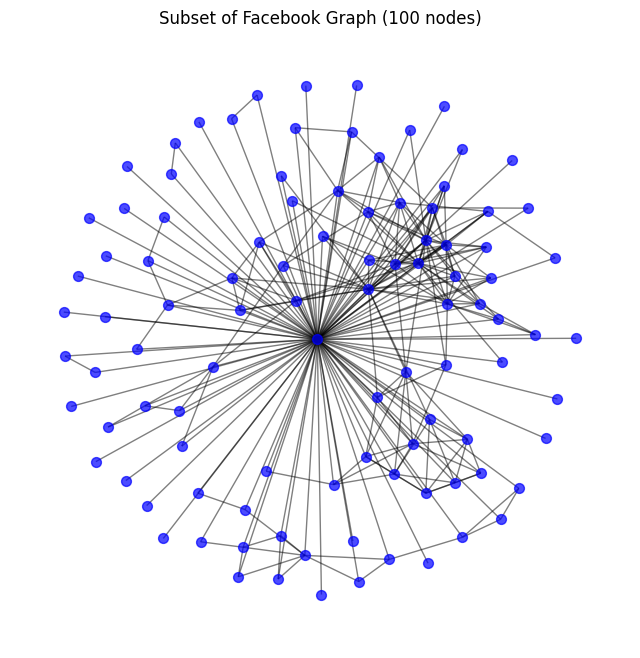

In [3]:
# Sample 100 nodes for visualization
subset_nodes = list(G_fb.nodes())[:100] 

# Create the subgraph from the subset of nodes
G_sub = G_fb.subgraph(subset_nodes)

# Draw the subgraph
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G_sub, seed=42) 
nx.draw_networkx_nodes(G_sub, pos, node_size=50, node_color='blue', alpha=0.7)
nx.draw_networkx_edges(G_sub, pos, alpha=0.5)
plt.title('Subset of Facebook Graph (100 nodes)')
plt.axis('off')
plt.show()

This visualization shows a subset of 100 nodes from the Facebook social graph, where each blue dot represents a user and each line shows a friendship link. The graph highlights how some users act have many direct connections, while others have less, illustrating the structure of social networks where there can be influential users connecting to many other users, and otherwise.

### 1.2 Preliminary Analysis

Now, let's analyze the graph's basic properties and identify the most important nodes.

In [4]:
n_nodes = G_fb.number_of_nodes()
n_edges = G_fb.number_of_edges()
avg_degree = (2 * n_edges) / n_nodes
density = nx.density(G_fb)

print(f"Dataset: Facebook Social Network")
print(f"Nodes: {n_nodes}")
print(f"Edges: {n_edges}")
print(f"Average Degree: {avg_degree:.4f}")
print(f"Graph Density: {density:.6f}")

# Check if the graph is connected
if nx.is_connected(G_fb):
    print("Graph is connected.")
else:
    print(f"Graph is not connected. Components: {nx.number_connected_components(G_fb)}")

Dataset: Facebook Social Network
Nodes: 4039
Edges: 88234
Average Degree: 43.6910
Graph Density: 0.010820
Graph is connected.


**Key Insights**

- With 4,039 users (represented by nodes), this is quite a small sample of Facebook's social network. There are also 88,234 edges which represents the same number of friendship links between users. 
- The average degree is computed to be 43.69, which means that on average, each user has around 44 friends. 
- The graph density is 0.011 which means the graph is quite sparse, which is expected since users form clusters of friends rather than connecting to every user in the network. 
- The graph being connected is also expected for a social network, where every user is reachable to each other through friends of friends. 

#### Centrality Measurements



In [5]:
# Degree Centrality 
# This measures the number of friends a user has
deg_cent = nx.degree_centrality(G_fb)
top_5_degree = sorted(deg_cent.items(), key=lambda item: item[1], reverse=True)[:5]

print("\nTop 5 Nodes by Degree Centrality (Most 'Popular'):")
for node, centrality in top_5_degree:
    print(f"  Node {node}: {centrality:.4f} (Actual friends: {G_fb.degree[node]})")

# Betweenness Centrality 
# Measures how often a node lies on shortest paths between others (bridges)
bet_cent = nx.betweenness_centrality(G_fb, k=1000, seed=42)
top_5_betweenness = sorted(bet_cent.items(), key=lambda item: item[1], reverse=True)[:5]

print("\nTop 5 Nodes by Betweenness Centrality (Best 'Bridges'):")
for node, centrality in top_5_betweenness:
    print(f"  Node {node}: {centrality:.4f}")

# Closeness Centrality
# Measures how close a network node is to all other nodes (fastest access)
closeness_cent = nx.closeness_centrality(G_fb)
top_5_closeness = sorted(closeness_cent.items(), key=lambda item: item[1], reverse=True)[:5]

print("\nTop 5 Nodes by Closeness Centrality (Fastest access):")
for node, centrality in top_5_closeness:
    print(f"  Node {node}: {centrality:.4f}")



Top 5 Nodes by Degree Centrality (Most 'Popular'):
  Node 107: 0.2588 (Actual friends: 1045)
  Node 1684: 0.1961 (Actual friends: 792)
  Node 1912: 0.1870 (Actual friends: 755)
  Node 3437: 0.1355 (Actual friends: 547)
  Node 0: 0.0859 (Actual friends: 347)

Top 5 Nodes by Betweenness Centrality (Best 'Bridges'):
  Node 107: 0.4852
  Node 1684: 0.3449
  Node 3437: 0.2268
  Node 1912: 0.2232
  Node 0: 0.1520

Top 5 Nodes by Closeness Centrality (Fastest access):
  Node 107: 0.4597
  Node 58: 0.3974
  Node 428: 0.3948
  Node 563: 0.3939
  Node 1684: 0.3936


**Key Insights**
- Degree centrality counts the number of direct connections (friends) each node has. Nodes with high degree centrality are the most "popular" users since they have the most friends within the network. In this case, node 107 is the most "popular" user with 1045 friends.
- Betweenness centrality measures how often a node sits on the shortest paths between other pairs of nodes, thus acting as a bridge between nodes. Node 107 is also the best "bridge" in this case, which is expected since it connects to the most number of nodes.
- Closeness centrality measures how easily a node can reach all other nodes (by the path length to all other nodes). Interestingly, node 107 got the best centrality score yet again, which makes it the most important node based on these measures.
- Some nodes (e.g., node 58, node 428, node 563) appear in closeness but not in degree or betweenness, suggesting they have quick access to the nodes even if they aren't the most connected or the best bridges.


In [6]:
# Eigenvector Centrality
# Measures influence of a node in the network by the quality of its connections
eigen_cent = nx.eigenvector_centrality(G_fb, max_iter=1000, tol=1e-06)
top_5_eigen = sorted(eigen_cent.items(), key=lambda item: item[1], reverse=True)[:5]

print("\nTop 5 Nodes by Eigenvector Centrality (Influential nodes):")
for node, centrality in top_5_eigen:
    print(f"  Node {node}: {centrality:.4f}")

# Clustering Coefficient per node
# Measures the how nodes in a graph tend to cluster together
clustering_coeff = nx.clustering(G_fb)
top_5_clustering = sorted(clustering_coeff.items(), key=lambda item: item[1], reverse=True)[:10]

print("\nTop 10 Nodes by Clustering Coefficient (Local cohesiveness):")
for node, coeff in top_5_clustering:
    print(f"  Node {node}: {coeff:.4f}")


Top 5 Nodes by Eigenvector Centrality (Influential nodes):
  Node 1912: 0.0954
  Node 2266: 0.0870
  Node 2206: 0.0861
  Node 2233: 0.0852
  Node 2464: 0.0843

Top 10 Nodes by Clustering Coefficient (Local cohesiveness):
  Node 32: 1.0000
  Node 33: 1.0000
  Node 35: 1.0000
  Node 42: 1.0000
  Node 44: 1.0000
  Node 46: 1.0000
  Node 47: 1.0000
  Node 52: 1.0000
  Node 63: 1.0000
  Node 70: 1.0000


**Key Insights**
- Eigenvector centrality identifies nodes that are not only well-connected, but are connected to other well-connected nodes. A high eigenvector score means a node has connections to other nodes that themselves are influential. Node 1912 has the highest eigenvector centrality, which means it isn't just popular by degree, but its connections are also well-connected.
- Interestingly, node 107 which topped the previous 3 centrality measures doesn't show up here, which suggests that its connections aren't that influential.
- The clustering coefficient measures the extent to which a node's neighbors are also connected to one another, showing the cohesion of a node's neighborhood. As shown above, the top 10 nodes all got a coefficient of 1.00 which shows that a lot of communities are very tightly knit where every user knows every other user within the network. This is a bit expected from social networks, since there may be groups like families or school groups where we expect everyone knowing everyone else.

In [7]:
# PageRank Centrality
# Measures influence using a random walk model
pagerank_cent = nx.pagerank(G_fb, alpha=0.85)
top_5_pagerank = sorted(pagerank_cent.items(), key=lambda item: item[1], reverse=True)[:5]

print("\nTop 5 Nodes by PageRank:")
for node, centrality in top_5_pagerank:
    print(f"  Node {node}: {centrality:.4f}")

# Katz Centrality
# Measures influence considering both direct and indirect connections
katz_cent = nx.katz_centrality_numpy(G_fb, alpha=0.1, beta=1.0)
top_5_katz = sorted(katz_cent.items(), key=lambda item: item[1], reverse=True)[:5]

print("\nTop 5 Nodes by Katz Centrality:")
for node, centrality in top_5_katz:
    print(f"  Node {node}: {centrality:.4f}")


Top 5 Nodes by PageRank:
  Node 3437: 0.0076
  Node 107: 0.0069
  Node 1684: 0.0064
  Node 0: 0.0063
  Node 1912: 0.0039

Top 5 Nodes by Katz Centrality:
  Node 2696: 0.1064
  Node 2921: 0.0998
  Node 2934: 0.0947
  Node 3275: 0.0850
  Node 2870: 0.0837


**Key Insights**
- PageRank estimates the importance of a node by considering the quantity and quality of its inbound links. This reflects nodes that are frequently visited in a random walk across the network, which signifies how influential it is.
- Interestingly, the PageRank overlaps with the Degree centrality results, albeit with a different order. This is a bit expected due to the nature of PageRank which measures centrality based on inbound links. However, the order changed because there is a measure of link quality as well, which suggests that some links aren't as good as others, even if there are more links in a node.
- Katz centrality counts all walks that lead to a node. This measure obtains nodes that have extended influence in the network, potentially acting as connectors over other paths. We added this to test it out, and it is quite interesting how the nodes here are completely different from the other centrality scores. This could be attributed to the fact that it considers indirect paths as well, and not just the nodes that are directly connected to a user.

#### Visualizations

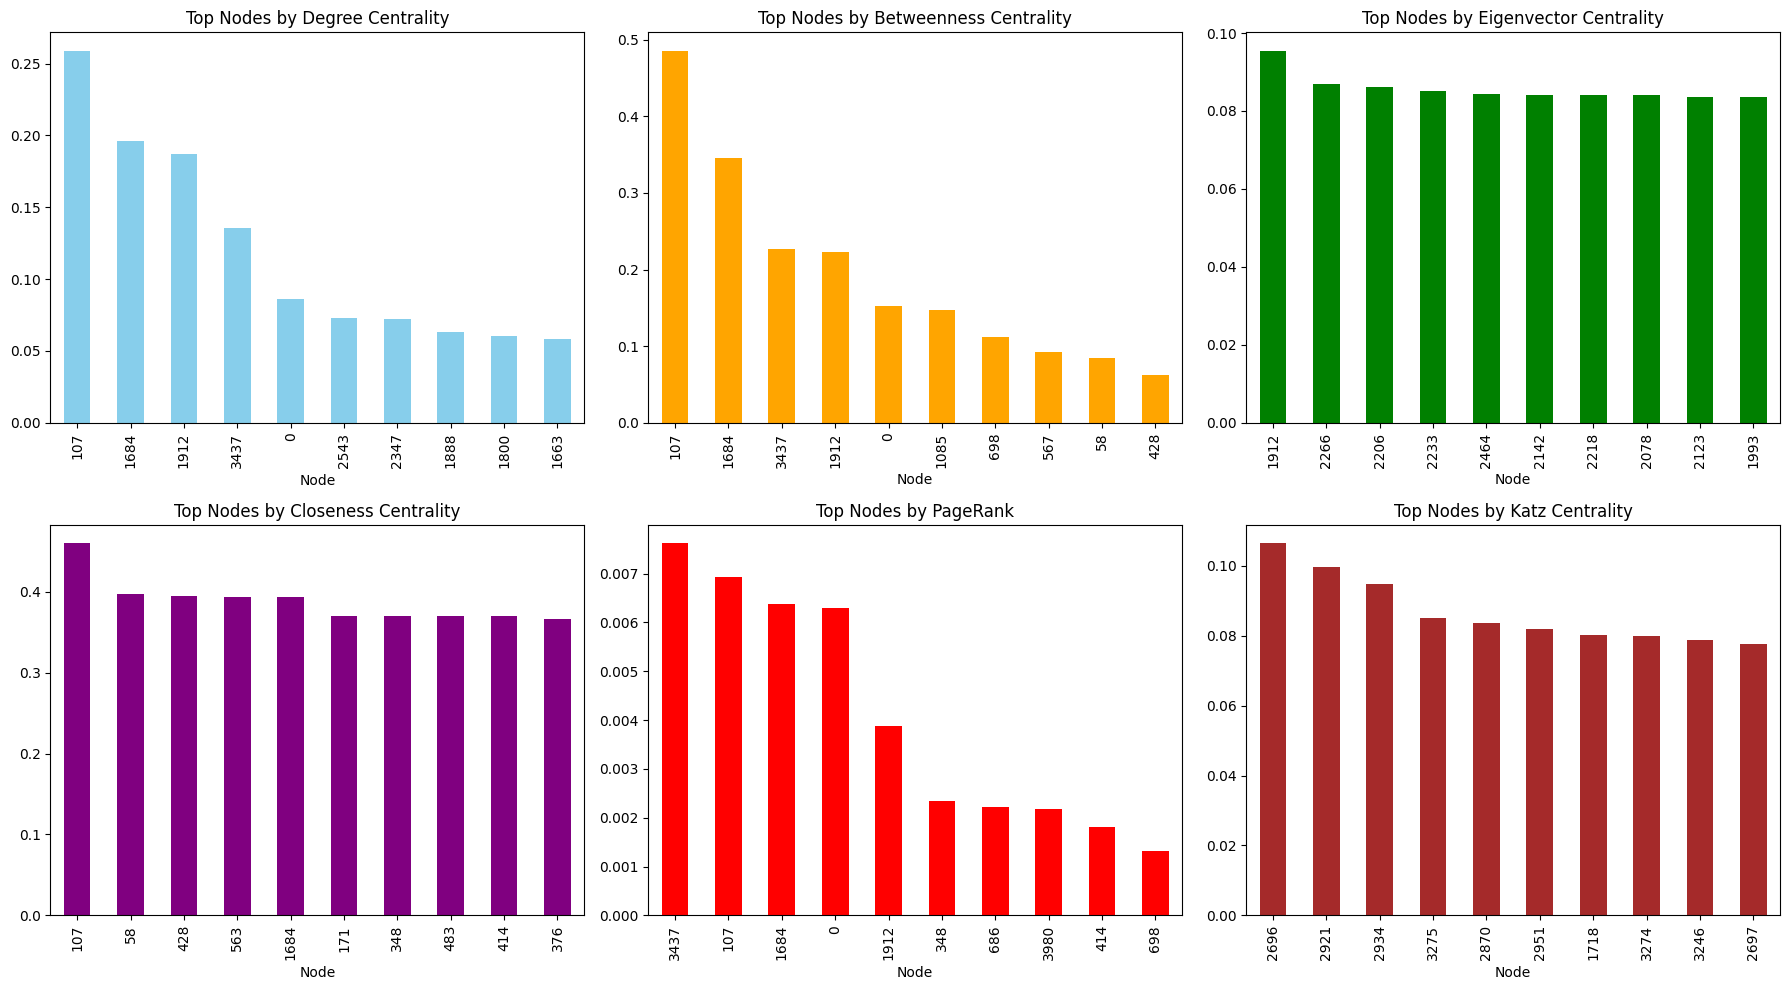

In [8]:
def top_n_df(centrality_dict, n=10):
    top_items = sorted(centrality_dict.items(), key=lambda item: item[1], reverse=True)[:n]
    return pd.DataFrame(top_items, columns=['Node', 'Centrality'])

centrality_dicts = [
    (deg_cent, 'Degree Centrality', 'skyblue'),
    (bet_cent, 'Betweenness Centrality', 'orange'),
    (eigen_cent, 'Eigenvector Centrality', 'green'),
    (closeness_cent, 'Closeness Centrality', 'purple'),
    (pagerank_cent, 'PageRank', 'red'),
    (katz_cent, 'Katz Centrality', 'brown')
]
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for ax, (cent_dict, title, color) in zip(axes.flatten(), centrality_dicts):
    top_n_df(cent_dict).plot.bar(x='Node', y='Centrality', legend=False, ax=ax, color=color)
    ax.set_title(f'Top Nodes by {title}')

plt.tight_layout()
plt.show()


**Key Insights**
- This basically just visualized the same values that were obtained previously. This makes it easier to see how much more influential nodes can be for some centrality measurements over others. For instance, Node 107 has a much higher degree and betweenness measurement over other nodes, but when we look at the eigenvector, Katz and closeness centralities, the centrality measurements are much closer to each other. Pagerank shows a sudden drop after the top 4 nodes, highlighting the difference between highly influential nodes and the rest of the network, and how influence is distributed unevenly.

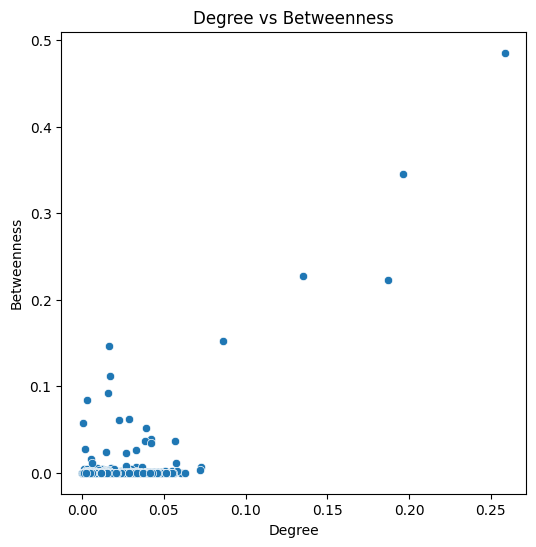

In [17]:
# Scatter plots between degree vs betweenness
df_degree = pd.DataFrame(list(deg_cent.items()), columns=['Node', 'Degree'])
df_betweenness = pd.DataFrame(list(bet_cent.items()), columns=['Node', 'Betweenness'])
df_merged = pd.merge(df_degree, df_betweenness, on='Node')
plt.figure(figsize=(6,6))
sns.scatterplot(data=df_merged, x='Degree', y='Betweenness')
plt.title('Degree vs Betweenness')
plt.show()

This scatter plot shows the relationship between degree and betweenness centrality. Most nodes have low values on both measures, but a few stand out as having both high degree and high betweenness, indicating they function as key connectors in the network. Generally, nodes with higher degrees also have higher betweenness measurements.

Comparing degree and betweenness centrality is relevant because it helps distinguish between nodes that are simply popular and those that play roles as bridges in the network. 

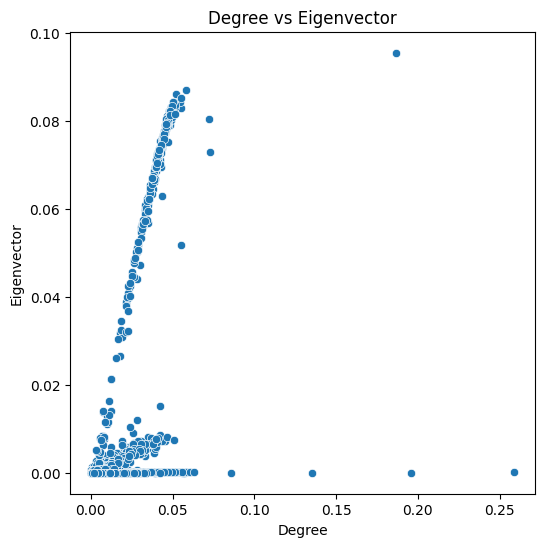

In [19]:
# Scatter plots between degree vs eigenvector
df_degree = pd.DataFrame(list(deg_cent.items()), columns=['Node', 'Degree'])
df_eigen = pd.DataFrame(list(eigen_cent.items()), columns=['Node', 'Eigenvector'])
df_merged = pd.merge(df_degree, df_eigen, on='Node')
plt.figure(figsize=(6,6))
sns.scatterplot(data=df_merged, x='Degree', y='Eigenvector')
plt.title('Degree vs Eigenvector')
plt.show()

This scatter plot shows the relationship between degree centrality and eigenvector centrality. While the general trend goes upward, where most nodes with higher degree also have higher eigenvector centrality, there are some outliers with high degree but low eigevector scores, suggesting that some "popular" nodes don't really have good quality connections.

It's interesting to compare degree and eigenvector centrality because degree measures just  popularity, while eigenvector centrality captures a node's influence through connections with other influential nodes. This distinction helps reveal whether popular nodes are also truly impactful in the entire network.

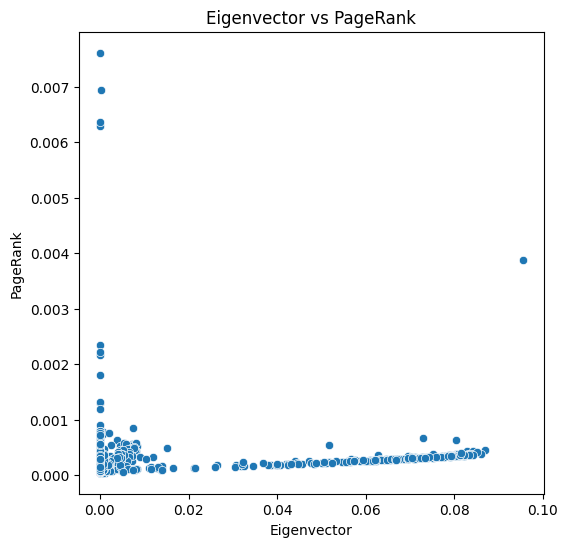

In [18]:
# Scatter plot between eigenvector vs pagerank
df_eigen = pd.DataFrame(list(eigen_cent.items()), columns=['Node', 'Eigenvector'])
df_pagerank = pd.DataFrame(list(pagerank_cent.items()), columns=['Node', 'PageRank'])
df_merged2 = pd.merge(df_eigen, df_pagerank, on='Node')
plt.figure(figsize=(6,6))
sns.scatterplot(data=df_merged2, x='Eigenvector', y='PageRank')
plt.title('Eigenvector vs PageRank')
plt.show()

This scatter plot compares eigenvector centrality and PageRank for each node. Most nodes have low values for both centralities, but a few outliers stand out with high eigenvector centrality but relatively low Pagerank, and vice versa. This suggests that they rank certain nodes differently depending on the structure of their connections and the type of influence being measured.​

It's interesting to compare them because they emphasize different aspects of the network. Eigenvector centrality assigns importance based on connectivity to other influential nodes, while PageRank takes into account the quality of incoming links, resulting in distinct rankings for certain nodes depending on network structure.

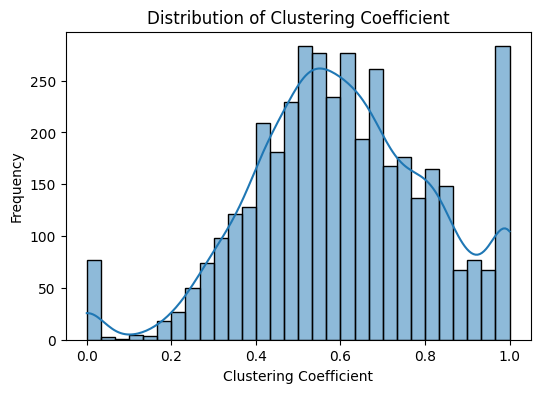

In [10]:
# Histogram of clustering coefficient
plt.figure(figsize=(6,4))
sns.histplot(list(clustering_coeff.values()), bins=30, kde=True)
plt.title('Distribution of Clustering Coefficient')
plt.xlabel('Clustering Coefficient')
plt.ylabel('Frequency')
plt.show()

his histogram displays the distribution of clustering coefficients in the network. Most nodes have moderate to high local clustering, indicating that users tend to form tightly-connected friend groups; a notable peak at 1.0 shows many perfect cliques, while the left tail reflects users with few mutual connections among their friends. Interestingly, there are some nodes which have 0 clustering coefficient, suggesting that their friends are not friends with each other.

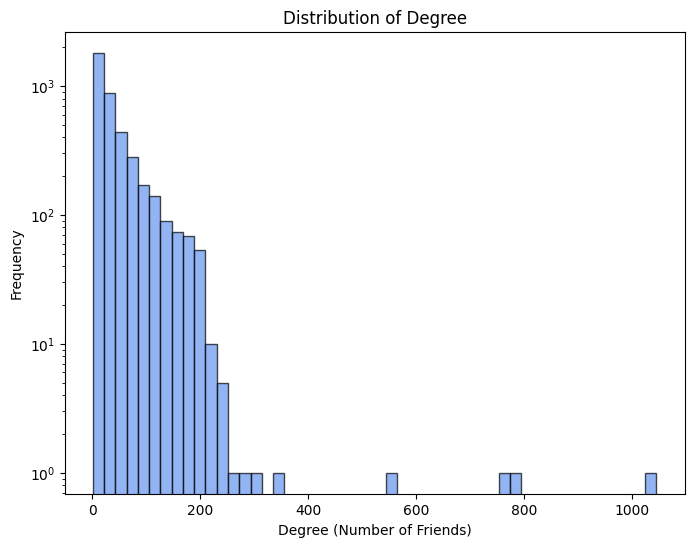

In [23]:
# Get degree sequence
degree_sequence = [degree for node, degree in G_fb.degree()]

plt.figure(figsize=(8, 6))
plt.hist(degree_sequence, bins=50, color='cornflowerblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Degree')
plt.xlabel('Degree (Number of Friends)')
plt.ylabel('Frequency')
plt.yscale('log')  
plt.show()


This histogram shows the degree distribution of the network, showing that most users have a relatively low number of friends, while a few nodes act as very popular nodes with hundreds or even more than a thousand friends. The long tail and rapid drop make sense in social networks, where there should be very few users who are truly popular and have lots of connections.

### 1.3 Community Detection Algorithms

In [51]:
# Community Detection using the Louvain Method
print("Running Louvain algorithm on Facebook graph.")
start_time = time.time()
partition_louvain = community_louvain.best_partition(G_fb)
louvain_time = time.time() - start_time

# Get statistics
num_communities_louvain = len(set(partition_louvain.values()))
community_sizes_louvain = Counter(partition_louvain.values())

print(f"Louvain finished in {louvain_time:.4f} seconds.")
print(f"Louvain found {num_communities_louvain} communities.")
print(f"Top 5 largest communities (size):")
print(community_sizes_louvain.most_common(5))
    

Running Louvain algorithm on Facebook graph.
Louvain finished in 0.8004 seconds.
Louvain found 15 communities.
Top 5 largest communities (size):
[(5, 554), (9, 548), (1, 432), (8, 432), (4, 423)]


In [52]:
# Community Detection using Label Propagation Algorithm (LPA)
print("\nRunning Label Propagation (LPA) on Facebook graph.")
start_time = time.time()
communities_lpa_sets = nx.community.label_propagation_communities(G_fb)
communities_lpa_list = [c for c in communities_lpa_sets]
lpa_time = time.time() - start_time

# Get statistics
num_communities_lpa = len(communities_lpa_list)
community_sizes_lpa = sorted([len(c) for c in communities_lpa_list], reverse=True)

print(f"LPA finished in {lpa_time:.4f} seconds.")
print(f"LPA found {num_communities_lpa} communities.")
print(f"Top 5 largest communities (size):")
print(community_sizes_lpa[:5])


Running Label Propagation (LPA) on Facebook graph.
LPA finished in 0.2273 seconds.
LPA found 44 communities.
Top 5 largest communities (size):
[1030, 753, 547, 469, 226]


In [53]:
# Community Detection using Walktrap Algorithm
print("\nRunning Walktrap algorithm on Facebook graph.")
G_fb_ig = ig.Graph.from_networkx(G_fb)
start_time = time.time()
dendrogram = G_fb_ig.community_walktrap()
clusters_walktrap = dendrogram.as_clustering()
walktrap_time = time.time() - start_time

# Get statistics
num_communities_walktrap = len(clusters_walktrap)
community_sizes_walktrap = sorted(clusters_walktrap.sizes(), reverse=True)

print(f"Walktrap finished in {walktrap_time:.4f} seconds.")
print(f"Walktrap found {num_communities_walktrap} communities.")
print(f"Top 5 largest communities (size):")
print(community_sizes_walktrap[:5])


Running Walktrap algorithm on Facebook graph.
Walktrap finished in 1.3279 seconds.
Walktrap found 77 communities.
Top 5 largest communities (size):
[481, 424, 286, 232, 226]


In [59]:
communities_louvain_list = [set() for _ in range(num_communities_louvain)]
for node, community_id in partition_louvain.items():
    communities_louvain_list[community_id].add(node)

# Computing modularity scores for each algorithm
mod_louvain = nx.community.modularity(G_fb, communities_louvain_list)
mod_lpa = nx.community.modularity(G_fb, communities_lpa_list)
mod_walktrap = G_fb_ig.modularity(clusters_walktrap)

print("\n--- Comparison of Algorithms ---")
print("Algorithm  | Modularity | Num Communities | Time (s)")
print("-----------|------------|-----------------|----------")
print(f"Louvain    | {mod_louvain:.8f} | {num_communities_louvain:<15} | {louvain_time:.4f}")
print(f"LPA        | {mod_lpa:.8f} | {num_communities_lpa:<15} | {lpa_time:.4f}")
print(f"Walktrap   | {mod_walktrap:.8f} | {num_communities_walktrap:<15} | {walktrap_time:.4f}")


--- Comparison of Algorithms ---
Algorithm  | Modularity | Num Communities | Time (s)
-----------|------------|-----------------|----------
Louvain    | 0.83488203 | 15              | 0.8004
LPA        | 0.73684073 | 44              | 0.2273
Walktrap   | 0.81193996 | 77              | 1.3279


**Key Insights**
1. **Modularity:** Louvain achieves the highest modularity, which is expected as its goal is to optimize this specific metric. Walktrap also achieves a very high score, nearly identical to Louvain's. LPA got the lowest Modularity.
2. **Speed:** LPA is by far the fastest, followed by Louvain. Walktrap is the slowest of the three.
3. **Community Structure:** Louvain finds the least amount of communities, followed by LPA and then Walktrap.

**Conclusion:** All three algorithms successfully find a strong community structure (high modularity scores). Louvain achieves the highest modularity (0.83) and finds a moderate number of communities (15), indicating it produces well-separated, high-quality groups, making it excellent for uncovering strong community structure in networks. LPA is the fastest method and finds many more (44) communities, but its modularity is noticeably lower (0.73), suggesting it may oversegment the network into smaller, less cohesive groups. It is a good method if speed is the highest priority. Walktrap yields moderate modularity (0.81) but discovers the largest number of communities (77), taking slightly longer to compute.


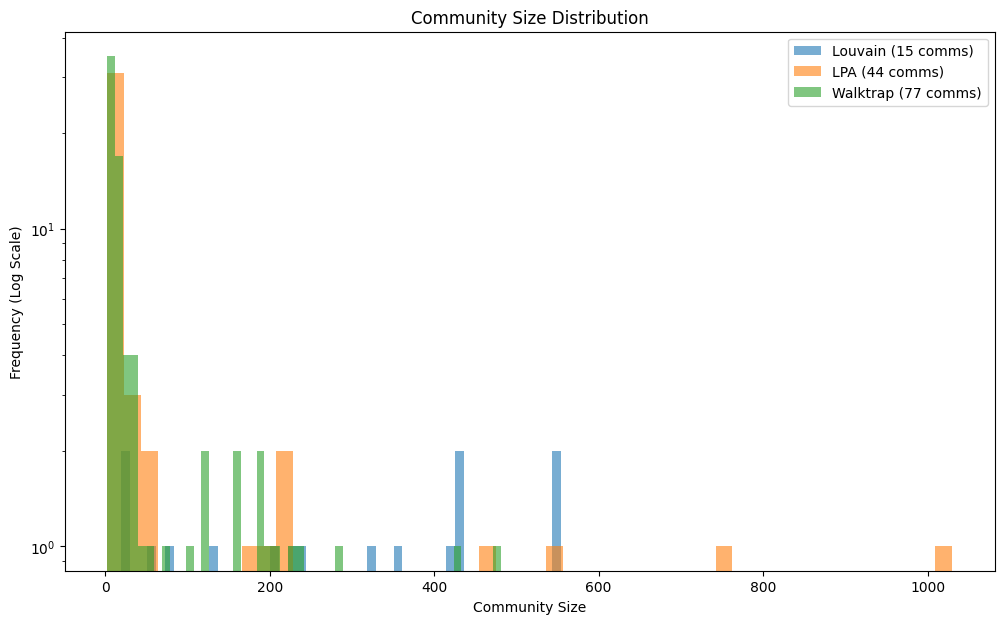

In [60]:
# Generating community size distribution plot
louvain_sizes = [s for s in community_sizes_louvain.values()]
lpa_sizes = community_sizes_lpa
walktrap_sizes = community_sizes_walktrap

plt.figure(figsize=(12, 7))
plt.hist(louvain_sizes, bins=50, log=True, alpha=0.6, label=f'Louvain ({num_communities_louvain} comms)')
plt.hist(lpa_sizes, bins=50, log=True, alpha=0.6, label=f'LPA ({num_communities_lpa} comms)')
plt.hist(walktrap_sizes, bins=50, log=True, alpha=0.6, label=f'Walktrap ({num_communities_walktrap} comms)')
plt.title('Community Size Distribution')
plt.xlabel('Community Size')
plt.ylabel('Frequency (Log Scale)')
plt.legend()

This community size distribution plot compares the output of three algorithms and shows that all tend to identify many small communities and a few larger ones. Louvain consistently finds fewer, larger communities, while Walktrap and LPA detect more but mostly small groups. 

Interestingly, LPA found the largest community with size ~1000, while the bulk of communities returned by Walktrap had sizes <100. Louvain had moderately sized communities with the bulk between 400 and 600.

#### Analyzing the Centrality of Communities

Now, let's analyze the centrality within the communities. For this, we use the Louvain communities for analysis.

In [66]:
# Create dictionaries to hold aggregate scores
comm_avg_degree = defaultdict(float)
comm_avg_betweenness = defaultdict(float)
comm_counts = defaultdict(int)

# Sum up the scores for each community
for node, comm_id in partition_louvain.items():
    comm_avg_degree[comm_id] += deg_cent[node]
    comm_avg_betweenness[comm_id] += bet_cent[node]
    comm_counts[comm_id] += 1

# Calculate the average
for comm_id in comm_avg_degree:
    comm_avg_degree[comm_id] /= comm_counts[comm_id]
    comm_avg_betweenness[comm_id] /= comm_counts[comm_id]

top_5_dense_comms = sorted(comm_avg_degree.items(), key=lambda x: x[1], reverse=True)[:5]
top_5_bridge_comms = sorted(comm_avg_betweenness.items(), key=lambda x: x[1], reverse=True)[:5]

print("\nTop 5 Communities (by Average Degree Centrality):")
for comm_id, avg_val in top_5_dense_comms:
    print(f"  Community {comm_id} (Size: {comm_counts[comm_id]}): {avg_val:.4f}")

print("\nTop 5 Communities (by Average Betweenness Centrality):")
for comm_id, avg_val in top_5_bridge_comms:
    print(f"  Community {comm_id} (Size: {comm_counts[comm_id]}): {avg_val:.4f}")


Top 5 Communities (by Average Degree Centrality):
  Community 11 (Size: 237): 0.0355
  Community 8 (Size: 432): 0.0198
  Community 4 (Size: 423): 0.0141
  Community 3 (Size: 226): 0.0126
  Community 10 (Size: 73): 0.0109

Top 5 Communities (by Average Betweenness Centrality):
  Community 8 (Size: 432): 0.0012
  Community 14 (Size: 206): 0.0012
  Community 13 (Size: 60): 0.0009
  Community 4 (Size: 423): 0.0009
  Community 1 (Size: 432): 0.0009


By analyzing the centrality within the communities, we can see that communities are not equal. Some communities have very dense core groups with the degrees higher within the community, while other communities have more bridges and more effectively connects different parts of the network.

As shown above, community 11 has the densest average degree centrality, while community 8 has the most bridge nodes. Noticeably, community 8 also has the second best average degree, which shows the quality of the community.

#### Visualizing the Communities

Text(0.5, 1.0, 'Visualization of Community 4 (Blue) and its Neighbors (Orange)')

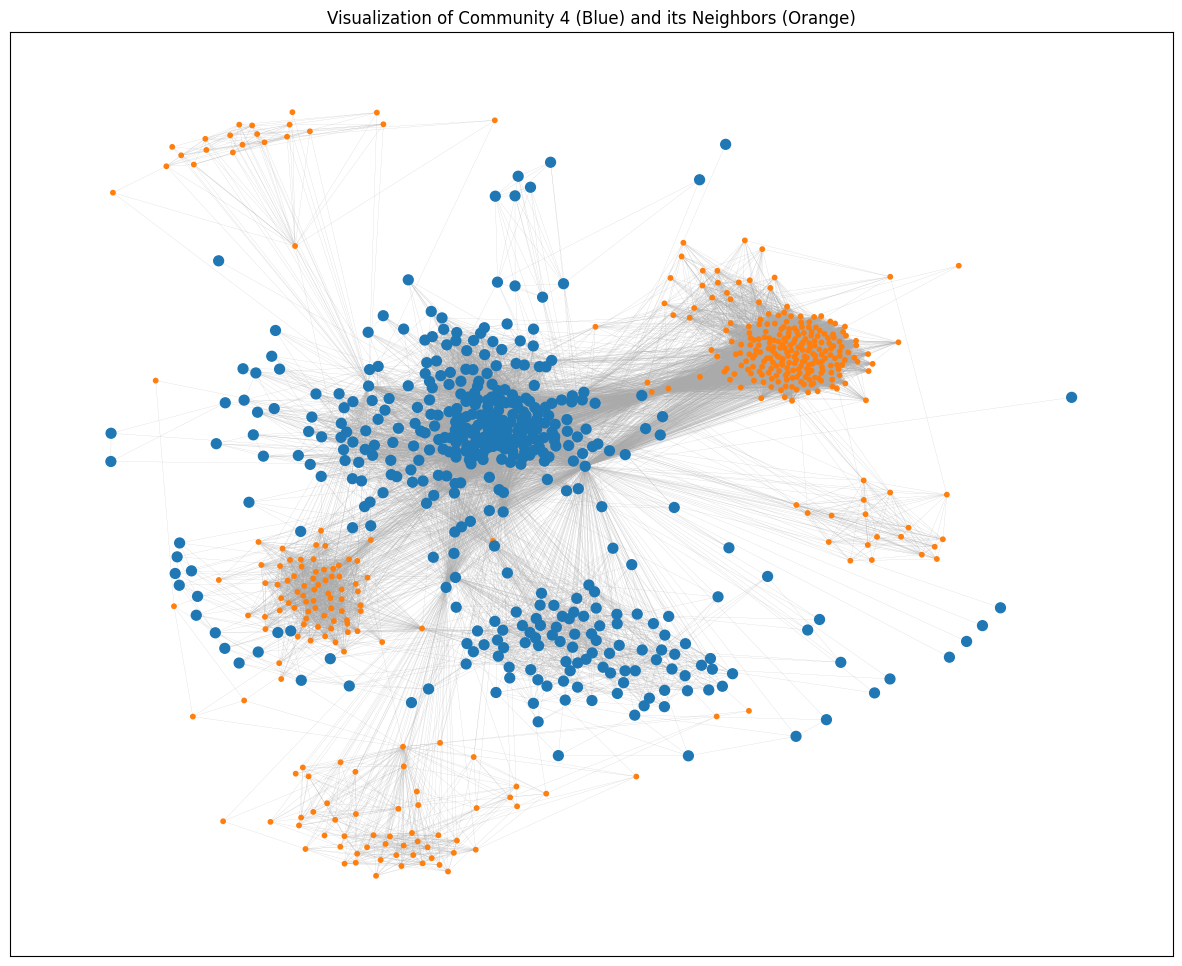

In [70]:
# Visualizing a subset community from Louvain
target_comm_id = community_sizes_louvain.most_common(10)[4][0]
community_nodes = set()
for node, comm_id in partition_louvain.items():
    if comm_id == target_comm_id:
        community_nodes.add(node)

nodes_to_plot = set(community_nodes)
for node in community_nodes:
    for neighbor in G_fb.neighbors(node):
        nodes_to_plot.add(neighbor)
G_sub = G_fb.subgraph(nodes_to_plot)

color_map = []
size_map = []
for node in G_sub.nodes():
    if node in community_nodes:
        color_map.append('#1f77b4') # Blue for core
        size_map.append(50)         # Larger size for core
    else:
        color_map.append('#ff7f0e') # Orange for neighbors
        size_map.append(10)         # Smaller size for neighbors

pos = nx.spring_layout(G_sub, k=0.15, iterations=50, seed=42)

plt.figure(figsize=(15, 12))
nx.draw_networkx(
    G_sub,
    pos,
    node_color=color_map,
    node_size=size_map,
    with_labels=False,
    width=0.1,
    edge_color='#AAAAAA'
)
plt.title(f'Visualization of Community {target_comm_id} (Blue) and its Neighbors (Orange)')

**Key Insights:**

This visualization plots a single sample community (blue) and its immediate neighbors (orange). The blue nodes are, for the most part, densely packed together. This illustrates the high intra-community density that the Louvain algorithm successfully identified. The orange nodes which belong to other communities form their own distinct clusters. The connections between the blue and orange clusters are visibly sparser than the connections within the blue cluster.

Interestingly, there are blue nodes seen further from the community and physically close to the orange clusters. This is probably a consequence of the plotting pulling them towards both orange and blue clusters, but these are basically the neighbor nodes that connect both the clusters and are bridges to the rest of the network.

# Part 2: EMAIL-EU-CORE NETWORK ANALYSIS

### Data Loading and Description

Dataset: Email-Eu-Core (European Research Institution Email Network)

Description:
- A directed network of email communications between members of a large European research institution
- Nodes: Individual members of the institution
- Edges: Email communications where a directed edge from node A to node B indicates that person A sent at least one email to person B
- Ground truth: 42 departments (communities)

Network Properties:
- Type: Directed - edge direction matters (sender -> receiver)
- Nodes: 1,005 individuals
- Edges: 25,571 emails
- Communities: 42 departments

Real-world interpretation:
- Communities represent organizational departments
- Useful for understanding communication patterns in organizations
- Can reveal informal organizational structure vs formal hierarchy


In [2]:
G = nx.read_edgelist('data/email-Eu-core.txt', create_using=nx.DiGraph(), nodetype=int)

### Visualizing the Full Network

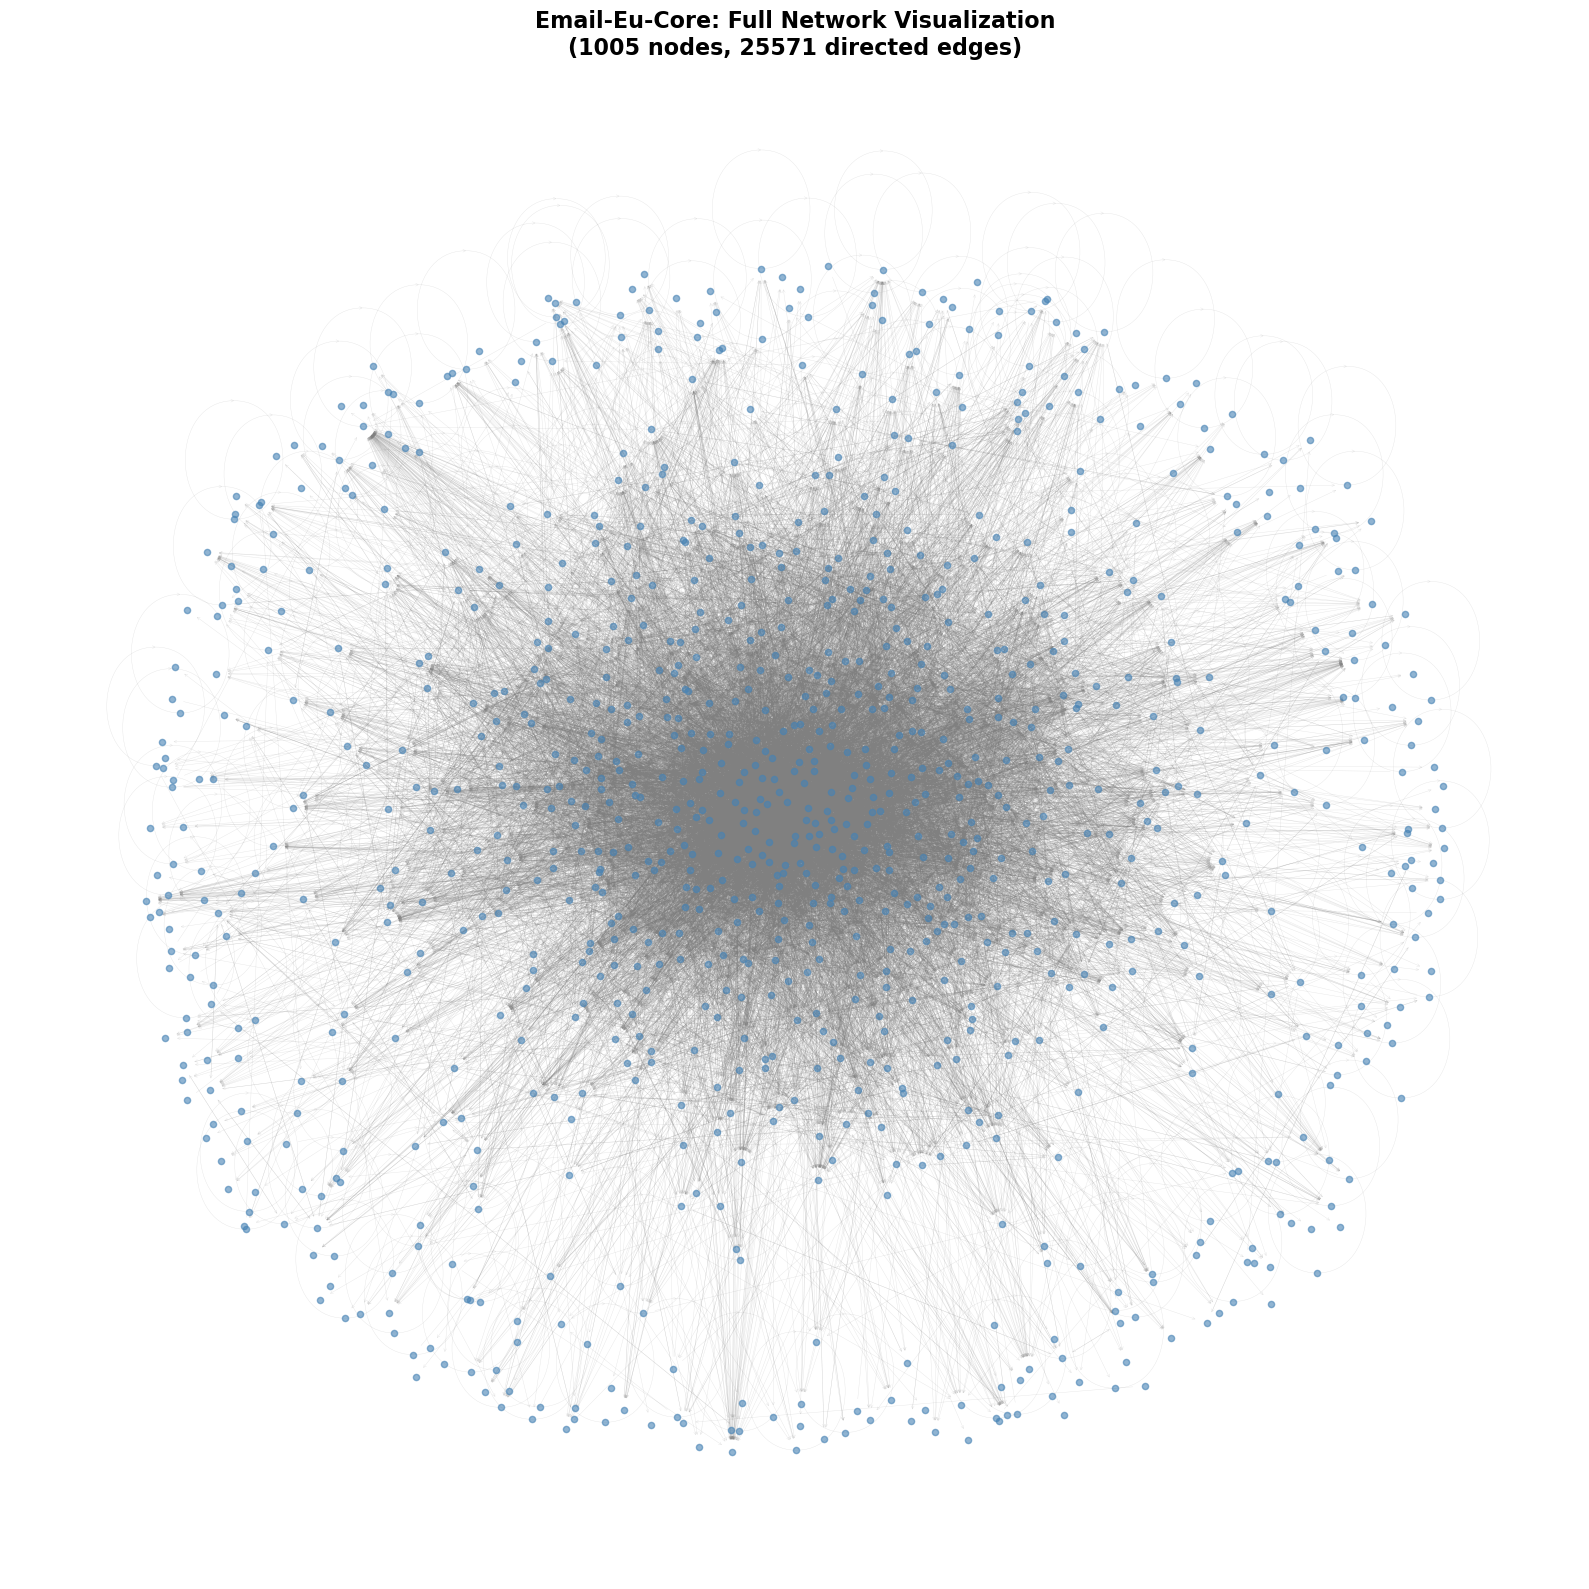

In [3]:
# visualizing the email-eu core network
plt.figure(figsize=(16, 16))

# positions for all nodes
pos_ecc = nx.spring_layout(G, k=0.5, iterations=50, seed=42)
nx.draw_networkx_nodes(G, pos_ecc, node_size=20, node_color='steelblue', alpha=0.6)
nx.draw_networkx_edges(G, pos_ecc, arrows=True, arrowsize=5, width=0.3, 
                        edge_color='gray', alpha=0.2, arrowstyle='->')

plt.title('Email-Eu-Core: Full Network Visualization\n(1005 nodes, 25571 directed edges)', 
          fontsize=16, fontweight='bold', pad=20)
plt.axis('off')  # Hide axes for cleaner look
plt.tight_layout()

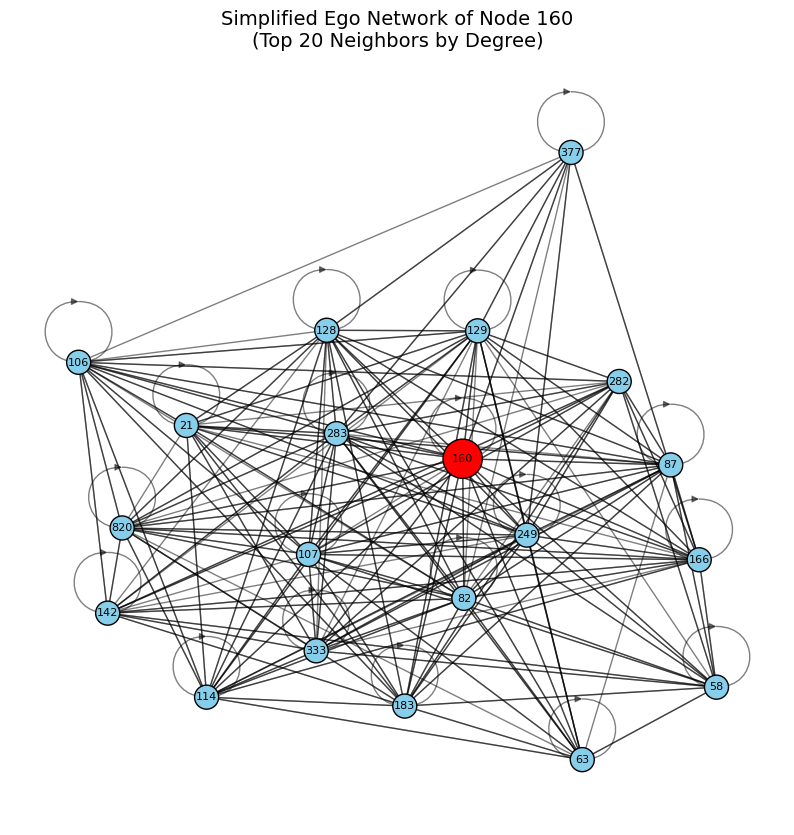

In [4]:
# Visualize a Subgraph (Ego network) to better understand the graph structure around
# Using the ego network of the highest-degree node

# Identify the node with the highest degree
# Compute degrees
degrees = dict(G.degree())
central_node = max(degrees, key=degrees.get)

# Create ego network
ego_graph = nx.ego_graph(G, central_node, radius=1)

# Sort neighbors by degree and keep only the top 20
neighbors = list(ego_graph.neighbors(central_node))
neighbor_degrees = {n: degrees[n] for n in neighbors}
top_neighbors = sorted(neighbor_degrees, key=neighbor_degrees.get, reverse=True)[:20]

# Subgraph with only central node + top neighbors
sub_ego = ego_graph.subgraph([central_node] + top_neighbors)

plt.figure(figsize=(10, 10))
pos_ego = nx.spring_layout(sub_ego, seed=42, k=0.7)

node_colors = ['red' if n == central_node else 'skyblue' for n in sub_ego.nodes()]
node_sizes = [800 if n == central_node else 300 for n in sub_ego.nodes()]

nx.draw_networkx_nodes(sub_ego, pos_ego, node_color=node_colors, node_size=node_sizes, edgecolors='black')
nx.draw_networkx_edges(sub_ego, pos_ego, width=1, alpha=0.5, arrows=False)
nx.draw_networkx_labels(sub_ego, pos_ego, font_size=8)

plt.title(f"Simplified Ego Network of Node {central_node}\n(Top 20 Neighbors by Degree)", fontsize=14)
plt.axis('off')
plt.show()

This visualization shows the ego network of node 160, where the red node represents the central user and the blue nodes are their top 20 most connected neighbors. Each line indicates an email interaction between two users. The dense pattern of interconnections among the blue nodes shows a highly cohesive communication cluster, suggesting that node 160 is not only highly active but also part of a tightly connected core group. This structure illustrates how some individuals in the email network act as key hubs, linking together many other well-connected users and facilitating information flow within the organization.

### Preliminary Statistics

In [5]:
# Basic Statistics 

# Number of nodes (individuals) in the email network
n_nodes = G.number_of_nodes()

# Number of edges (email communications)
n_edges = G.number_of_edges()

# Average degree (average number of connections per person)
# This tells us how connected people are on average
avg_degree = sum(dict(G.degree()).values()) / n_nodes

# Graph Density (ratio of actual edges to possible edges)
# If density = 0: no connections at all and If density = 1: everyone connected to everyone
# Social networks typically have low density (people don't connect to everyone)
density = nx.density(G)

# Weakly Connected: In a directed graph, "weakly connected" means any node can 
# be reached from any other node if the edge directions are ignored
# Strongly connected would require paths respecting direction
is_connected = nx.is_weakly_connected(G)

# Connected Components: Groups of nodes where each group is internally connected
# but isolated from other groups
n_components = nx.number_weakly_connected_components(G)

print(f"\nBasic Statistics:")
print(f"   • Number of nodes (people): {n_nodes:,}")
print(f"   • Number of edges (emails): {n_edges:,}")
print(f"   • Average degree: {avg_degree:.2f}")
print(f"   • Graph density: {density:.6f}")
print(f"   • Weakly connected: {is_connected}")
print(f"   • Number of weakly connected components: {n_components}")



Basic Statistics:
   • Number of nodes (people): 1,005
   • Number of edges (emails): 25,571
   • Average degree: 50.89
   • Graph density: 0.025342
   • Weakly connected: False
   • Number of weakly connected components: 20


In [6]:
# In-Degree: Number of incoming edges (emails RECEIVED by an individual)
# High in-degree = many people send emails to this person (could indicate authority, popularity, or being a help desk)
in_degrees = [d for n, d in G.in_degree()]

# Out-Degree: Number of outgoing edges (emails SENT by an individual)
# High out-degree = person sends emails to many others (could indicate managers, coordinators, or very social people)
out_degrees = [d for n, d in G.out_degree()]

print(f"\nDirected Graph Statistics:")
print(f"   • Average in-degree (emails received): {np.mean(in_degrees):.2f}")
print(f"   • Average out-degree (emails sent): {np.mean(out_degrees):.2f}")
print(f"   • Max in-degree: {max(in_degrees)}")
print(f"   • Max out-degree: {max(out_degrees)}")

# Reciprocity: Fraction of edges that are bidirectional (for example, A sends email to B AND B sends email to A)
# High reciprocity indicates mutual communication rather than one-way broadcasting
reciprocity = nx.reciprocity(G)
print(f"   • Reciprocity: {reciprocity:.4f}")



Directed Graph Statistics:
   • Average in-degree (emails received): 25.44
   • Average out-degree (emails sent): 25.44
   • Max in-degree: 212
   • Max out-degree: 334
   • Reciprocity: 0.6934


In [7]:
print("\n" + "="*80)
print("KEY INSIGHTS FROM PRELIMINARY ANALYSIS")
print("="*80)
print(f"""
• With {n_nodes:,} members, this represents a medium-sized institutional network.
• The {n_edges:,} directed edges represent actual email communications between members and indicate a highly active 
  communication network with substantial email traffic.
• Average degree of {avg_degree:.2f} means each person communicates with about 
  {int(avg_degree)} other members on average, suggesting active collaboration and cross-functional communication.
• The very low density ({density:.6f}) indicates a SPARSE network - people don't 
  email everyone, but rather focus on specific colleagues and collaborators.
• It has {n_components} weakly connected components (separate groups), meaning there are 20 distinct groups that are isolated from each other
• Reciprocity of {reciprocity:.4f} means {int(reciprocity*100)}% of email relationships are bidirectional (mutual communication). This indicates genuine collaboration rather than top-down broadcasting.
• The high max out-degree (334) suggests some nodes are "hubs" or central coordinators
  who communicate with a large fraction of the network (33% of all people) whule the high max in-degree (212) indicates certain individuals are key recipients of information, possibly in leadership or support roles.
""")  


KEY INSIGHTS FROM PRELIMINARY ANALYSIS

• With 1,005 members, this represents a medium-sized institutional network.
• The 25,571 directed edges represent actual email communications between members and indicate a highly active 
  communication network with substantial email traffic.
• Average degree of 50.89 means each person communicates with about 
  50 other members on average, suggesting active collaboration and cross-functional communication.
• The very low density (0.025342) indicates a SPARSE network - people don't 
  email everyone, but rather focus on specific colleagues and collaborators.
• It has 20 weakly connected components (separate groups), meaning there are 20 distinct groups that are isolated from each other
• Reciprocity of 0.6934 means 69% of email relationships are bidirectional (mutual communication). This indicates genuine collaboration rather than top-down broadcasting.
• The high max out-degree (334) suggests some nodes are "hubs" or central coordinators
  who

### Degree Distribution Analysis

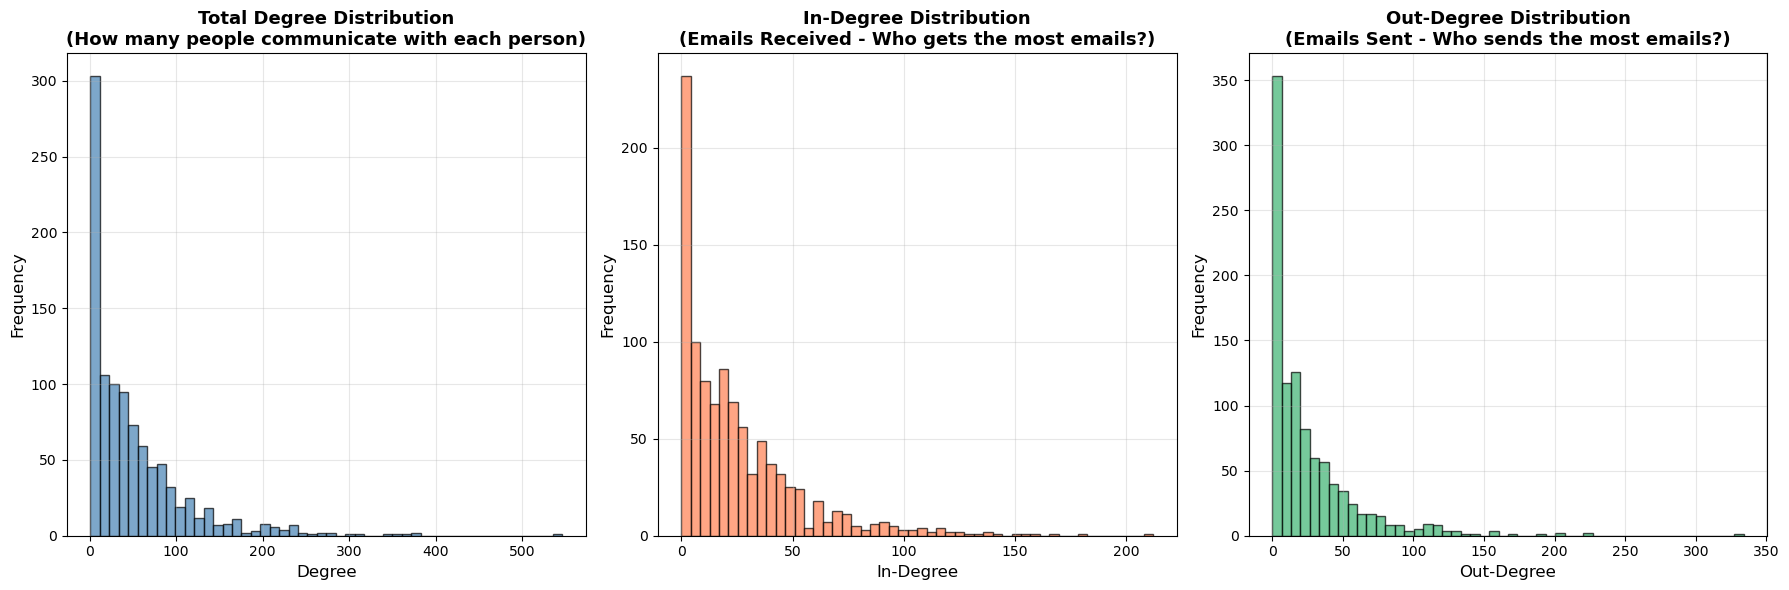

In [8]:
# Degree distribution shows how connections are distributed across the network
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Total degree distribution (in + out connections for each person)
degrees = [d for n, d in G.degree()]
axes[0].hist(degrees, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_xlabel('Degree', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Total Degree Distribution\n(How many people communicate with each person)', 
                  fontsize=13, fontweight='bold')
axes[0].grid(alpha=0.3)

# In-Degree distribution (shows how many people send emails TO each person)
axes[1].hist(in_degrees, bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[1].set_xlabel('In-Degree', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('In-Degree Distribution\n(Emails Received - Who gets the most emails?)', 
                  fontsize=13, fontweight='bold')
axes[1].grid(alpha=0.3)

# Out-Degree distribution (shows how many people each person sends emails TO)
axes[2].hist(out_degrees, bins=50, edgecolor='black', alpha=0.7, color='mediumseagreen')
axes[2].set_xlabel('Out-Degree', fontsize=12)
axes[2].set_ylabel('Frequency', fontsize=12)
axes[2].set_title('Out-Degree Distribution\n(Emails Sent - Who sends the most emails?)', 
                  fontsize=13, fontweight='bold')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()


The degree distributions show the following:

- Total degree: most nodes have few connections; a few hubs have many (heavy right tail).
- In-degree: most people receive emails from few distinct senders; a small tail of receivers get mail from many people.
- Out-degree: most people send to few others; a few send to many.

### Compute Centrality Measures

Centrality measures identify "important" nodes in a network, but "importance" can mean different things:
- Who has the most connections? (Degree)
- Who is most influential? (Eigenvector, PageRank)
- Who can reach others quickly? (Closeness, Harmonic)
- Who controls information flow? (Betweenness)
- Who is in tight-knit groups? (Clustering)

In [9]:
# For some centrality measures, we need an undirected version
G_undirected = G.to_undirected()

# Dictionary to hold all centrality measures
centralities = {}

# Degree Centrality
centralities['degree'] = nx.degree_centrality(G)

# Eigenvector Centrality
try:
    centralities['eigenvector'] = nx.eigenvector_centrality(G, max_iter=1000)
except:
    # If regular method doesn't converge, use numpy's more stable version
    centralities['eigenvector'] = nx.eigenvector_centrality_numpy(G)

# PageRank Centrality
centralities['pagerank'] = nx.pagerank(G)

# Clustering Coefficient
centralities['clustering'] = nx.clustering(G_undirected)

# Closeness Centrality
centralities['closeness'] = nx.closeness_centrality(G_undirected)

# Betweenness Centrality
centralities['betweenness'] = nx.betweenness_centrality(G, k=min(500, n_nodes))

# Katz Centrality
try:
    centralities['katz'] = nx.katz_centrality(G, alpha=0.005, max_iter=1000)
except:
    centralities['katz'] = nx.katz_centrality_numpy(G, alpha=0.005)

# Harmonic Centrality
centralities['harmonic'] = nx.harmonic_centrality(G_undirected)

# Create DataFrame with all centrality measures where each row is a node and each column is a centrality measure
df_centralities = pd.DataFrame(centralities)

# Summary statistics
print("\nCentrality Measures - Summary Statistics:")
df_centralities.describe()


Centrality Measures - Summary Statistics:


degree   eigenvector     pagerank   clustering    closeness  \
count  1005.000000  1.005000e+03  1005.000000  1005.000000  1005.000000   
mean      0.050685  1.969421e-02     0.000995     0.399355     0.379683   
std       0.059918  2.465295e-02     0.000882     0.251691     0.074865   
min       0.000996  1.225420e-23     0.000183     0.000000     0.000000   
25%       0.007968  2.996627e-03     0.000379     0.264337     0.343778   
50%       0.031873  1.023744e-02     0.000780     0.380520     0.388252   
75%       0.070717  2.607604e-02     0.001290     0.525641     0.424214   
max       0.543825  1.492083e-01     0.009412     1.000000     0.573848   

        betweenness         katz     harmonic  
count  1.005000e+03  1005.000000  1005.000000  
mean   1.288356e-03     0.031087   405.956769  
std    3.771154e-03     0.005354    84.266617  
min    0.000000e+00     0.026310     0.000000  
25%    3.214436e-07     0.027171   362.633333  
50%    1.191028e-04     0.029487   415.716667  
75%    1.002778e-03     0.032861   456.083333  
max    7.307258e-02     0.064558   655.500000

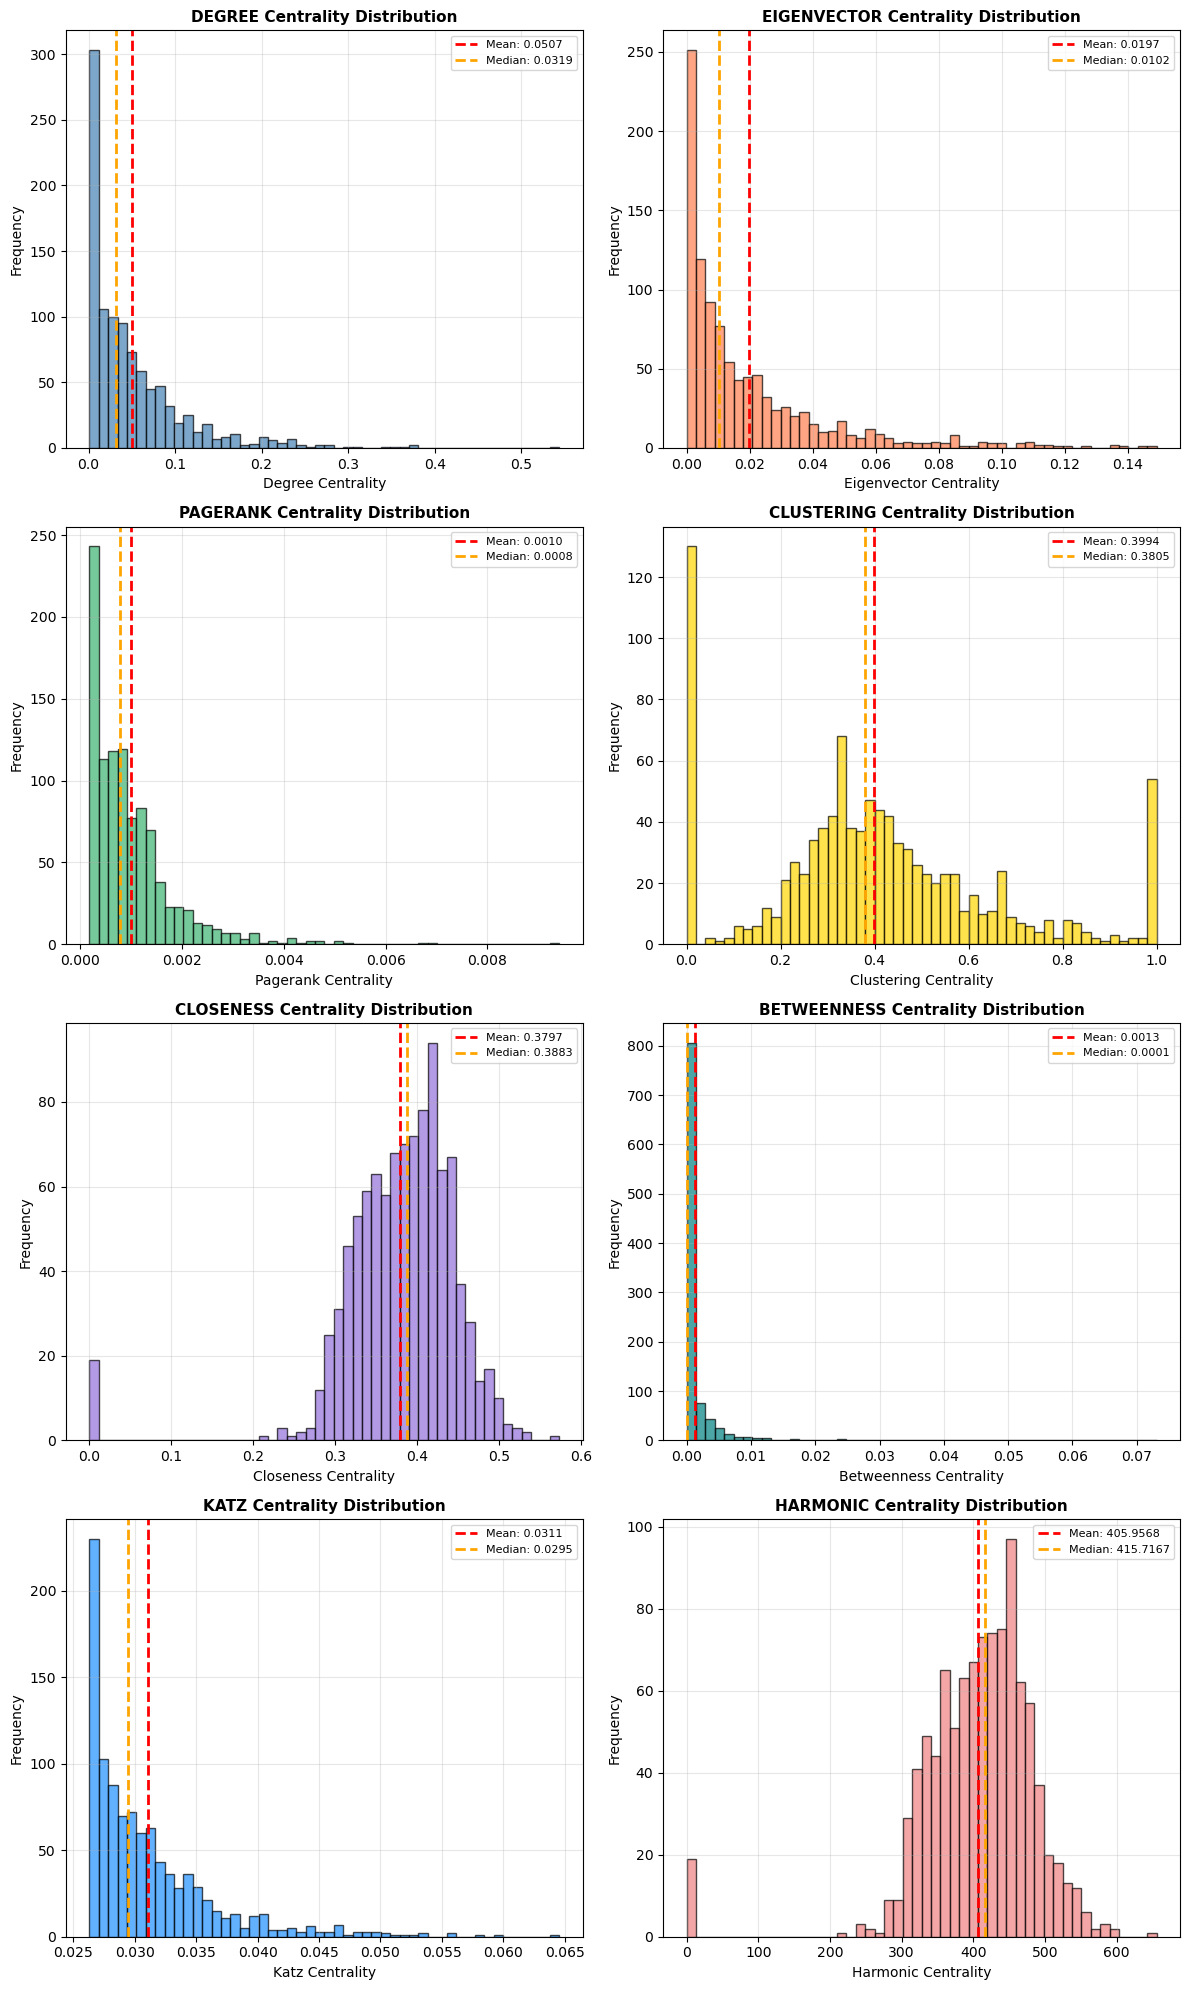

In [10]:
# Centrality Distribution Visualizations
# These histograms show how centrality scores are distributed across all nodes
# Helps understand if there are few dominant nodes (right-skewed) or 
# if centrality is evenly distributed (symmetric)

fig, axes = plt.subplots(4, 2, figsize=(12, 20))
axes = axes.ravel()

measures = list(centralities.keys())
colors = ['steelblue', 'coral', 'mediumseagreen', 'gold', 'mediumpurple', 
          'teal', 'dodgerblue', 'lightcoral']

for idx, (measure, color) in enumerate(zip(measures, colors)):
    values = list(centralities[measure].values())
    
    # Create histogram
    axes[idx].hist(values, bins=50, edgecolor='black', alpha=0.7, color=color)
    axes[idx].set_xlabel(f'{measure.capitalize()} Centrality', fontsize=10)
    axes[idx].set_ylabel('Frequency', fontsize=10)
    axes[idx].set_title(f'{measure.upper()} Centrality Distribution', 
                        fontsize=11, fontweight='bold')
    axes[idx].grid(alpha=0.3)
    
    # Add mean and median lines to show central tendency
    mean_val = np.mean(values)
    median_val = np.median(values)
    axes[idx].axvline(mean_val, color='red', linestyle='--', 
                      linewidth=2, label=f'Mean: {mean_val:.4f}')
    axes[idx].axvline(median_val, color='orange', linestyle='--', 
                      linewidth=2, label=f'Median: {median_val:.4f}')
    axes[idx].legend(fontsize=8)

plt.tight_layout()
plt.show()

#### Overall pattern of Centrality Measures

Most centrality measures are strongly right‑skewed: a small number of nodes score much higher than the rest (heavy tails).

A few nodes are clear “hubs”/influencers while most nodes have near-zero or low centrality for path-based metrics.


##### Per-plot highlights

1. Degree centrality: heavy right tail (mean > median). A few nodes connect to many others; most have low degree.
2. Eigenvector: right-skewed — a few nodes are connected to other well-connected nodes (influential).
3. PageRank: very small values, right-skewed — PageRank agrees with degree/eigenvector in highlighting a small top set.
4. Clustering coefficient: centered around ~0.38 with spikes at 0 and 1 — many nodes are in tight cliques or have no local clustering; network has many locally cohesive groups.
5. Closeness: roughly bell-shaped around ~0.38 — many nodes have similar global reach (can reach others in comparable path lengths).
6. Betweenness: extremely skewed with median ≈ 0 — almost all nodes are not important bridges; very few gatekeepers control shortest paths.
7. Katz: right-skewed but narrow — small set of nodes accumulate indirect-path influence.
8. Harmonic: fairly concentrated (mean ≈ median in the 300–500 range) — measures of reachability are more evenly distributed compared to path-centrality outliers.


Correlation between centrality measures shows:
- High correlation (close to 1): Measures capture similar aspects of importance
- Low correlation (close to 0): Measures capture different aspects of importance
- Negative correlation (close to -1): Measures capture opposite aspects

This helps us understand:
- Which centralities are redundant (high correlation)
- Which centralities provide unique information (low correlation)
- How different types of importance relate to each other



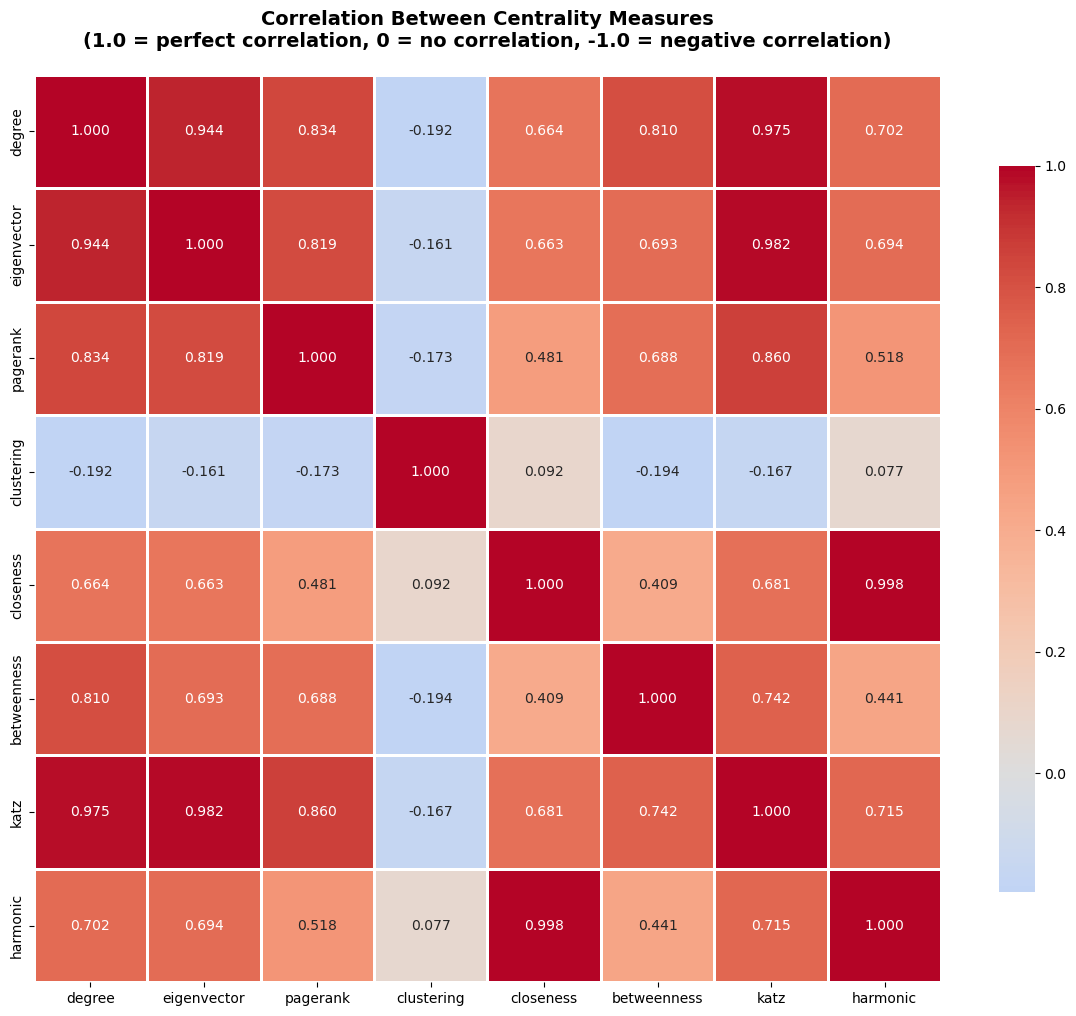

In [11]:
# Centrality Correlation Analysis
print("""
Correlation between centrality measures shows:
- High correlation (close to 1): Measures capture similar aspects of importance
- Low correlation (close to 0): Measures capture different aspects of importance
- Negative correlation (close to -1): Measures capture opposite aspects

This helps us understand:
- Which centralities are redundant (high correlation)
- Which centralities provide unique information (low correlation)
- How different types of importance relate to each other
""")

# Compute correlation matrix
correlation_matrix = df_centralities.corr()


# Visualize correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Between Centrality Measures\n(1.0 = perfect correlation, 0 = no correlation, -1.0 = negative correlation)', 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('centrality_correlations.png', dpi=300, bbox_inches='tight')
plt.show()

Highly similar/correlated measures include:
- degree,  katz, eigenvector, and pagerank (corr > 0.8) - connectivity
- clustering isn't similar to any other measure - tight knit groups
- closeness and harmonic (0.998) - they both measure closeness, but in different ways - reachability
- betweenness isn't as similar to others - acts as a bridge between other nodes

This shows that the similar measures measure similar properties

In [12]:
print("Top 5 Nodes by Each Centrality Measure")

# Create a dictionary to store top 5 for each measure
top_5_dict = {}

for measure in centralities.keys():
    print(f"\n{'-'*80}")
    print(f"TOP 5 NODES BY {measure.upper()} CENTRALITY")
    print('-'*80)
    
    # Get top 5 nodes for this measure
    top_5 = df_centralities.nlargest(5, measure)[measure]
    top_5_dict[measure] = top_5
    
    print(f"\nRank | Node ID | {measure.capitalize()} Score")
    print("-" * 50)
    
    for rank, (node, value) in enumerate(top_5.items(), 1):
        print(f"  {rank}  |  {node:4d}   | {value:.8f}")
    
    # Add interpretation for each measure
    if measure == 'degree':
        print("These nodes have the most direct connections (send/receive emails to/from most people).")
        print("They are the communication hubs and likely coordinate across many teams.")
        
    elif measure == 'eigenvector':
        print("These nodes are connected to other important/influential nodes.")
        print("Their importance comes from WHO they're connected to, not just how many.")
        
    elif measure == 'pagerank':
        print("These nodes receive emails from other important people (prestige/authority).")
        print("They are likely senior leaders, key decision-makers, or popular researchers.")
        
    elif measure == 'clustering':
        print("These nodes are embedded in tight-knit groups where everyone knows everyone.")
        print("They are team players within closely-connected departments or projects.")
        
    elif measure == 'closeness':
        print("These nodes can reach others through the shortest paths (central position).")
        print("Information spreads fastest from/to these individuals.")
        print("Note: May be affected by disconnected components in the network.")
        
    elif measure == 'betweenness':
        print("These nodes lie on many shortest paths between others (bridges/gatekeepers).")
        print("They control information flow and connect different communities.")
        print("Critical nodes: removing them would fragment the network significantly!")
        
    elif measure == 'katz':
        print("These nodes can be reached through many paths of varying lengths.")
        print("They have broad reachability and influence across the entire network.")
        
    elif measure == 'harmonic':
        print("These nodes are efficiently positioned to reach many others.")
        print("Better than closeness for disconnected networks - handles isolated groups well.")


Top 5 Nodes by Each Centrality Measure

--------------------------------------------------------------------------------
TOP 5 NODES BY DEGREE CENTRALITY
--------------------------------------------------------------------------------

Rank | Node ID | Degree Score
--------------------------------------------------
  1  |   160   | 0.54382470
  2  |   121   | 0.37749004
  3  |   107   | 0.37151394
  4  |    62   | 0.36752988
  5  |    86   | 0.35458167
These nodes have the most direct connections (send/receive emails to/from most people).
They are the communication hubs and likely coordinate across many teams.

--------------------------------------------------------------------------------
TOP 5 NODES BY EIGENVECTOR CENTRALITY
--------------------------------------------------------------------------------

Rank | Node ID | Eigenvector Score
--------------------------------------------------
  1  |   160   | 0.14920830
  2  |   107   | 0.14365502
  3  |    62   | 0.14008425
  4  |   4

In [13]:
# Create a summary DataFrame showing top 5 for all measures side by side
print("\nSummary table...")

# Build the summary table
summary_data = {}
for measure in centralities.keys():
    top_5 = df_centralities.nlargest(5, measure)
    # Store both node ID and score
    summary_data[f'{measure}_node'] = top_5.index.tolist()
    summary_data[f'{measure}_score'] = top_5[measure].tolist()

# Create DataFrame
max_len = 5  # Top 5
summary_df = pd.DataFrame(summary_data, index=[f'Rank {i+1}' for i in range(max_len)])

summary_df


Summary table...


degree_node  degree_score  eigenvector_node  eigenvector_score  \
Rank 1          160      0.543825               160           0.149208   
Rank 2          121      0.377490               107           0.143655   
Rank 3          107      0.371514                62           0.140084   
Rank 4           62      0.367530               434           0.136061   
Rank 5           86      0.354582               121           0.136024   

        pagerank_node  pagerank_score  clustering_node  clustering_score  \
Rank 1              1        0.009412              348               1.0   
Rank 2            130        0.006914              382               1.0   
Rank 3            160        0.006759              383               1.0   
Rank 4             62        0.005322              398               1.0   
Rank 5             86        0.005130              436               1.0   

        closeness_node  closeness_score  betweenness_node  betweenness_score  \
Rank 1             160         0.573848               160           0.073073   
Rank 2              82         0.534195                86           0.037724   
Rank 3             121         0.531259                 5           0.027522   
Rank 4             107         0.523772                62           0.024506   
Rank 5              62         0.522639               107           0.023833   

        katz_node  katz_score  harmonic_node  harmonic_score  
Rank 1        160    0.064558            160      655.500000  
Rank 2         62    0.059400             82      596.666667  
Rank 3        107    0.058290            121      595.333333  
Rank 4        121    0.056106            107      586.666667  
Rank 5        434    0.055448             86      584.500000

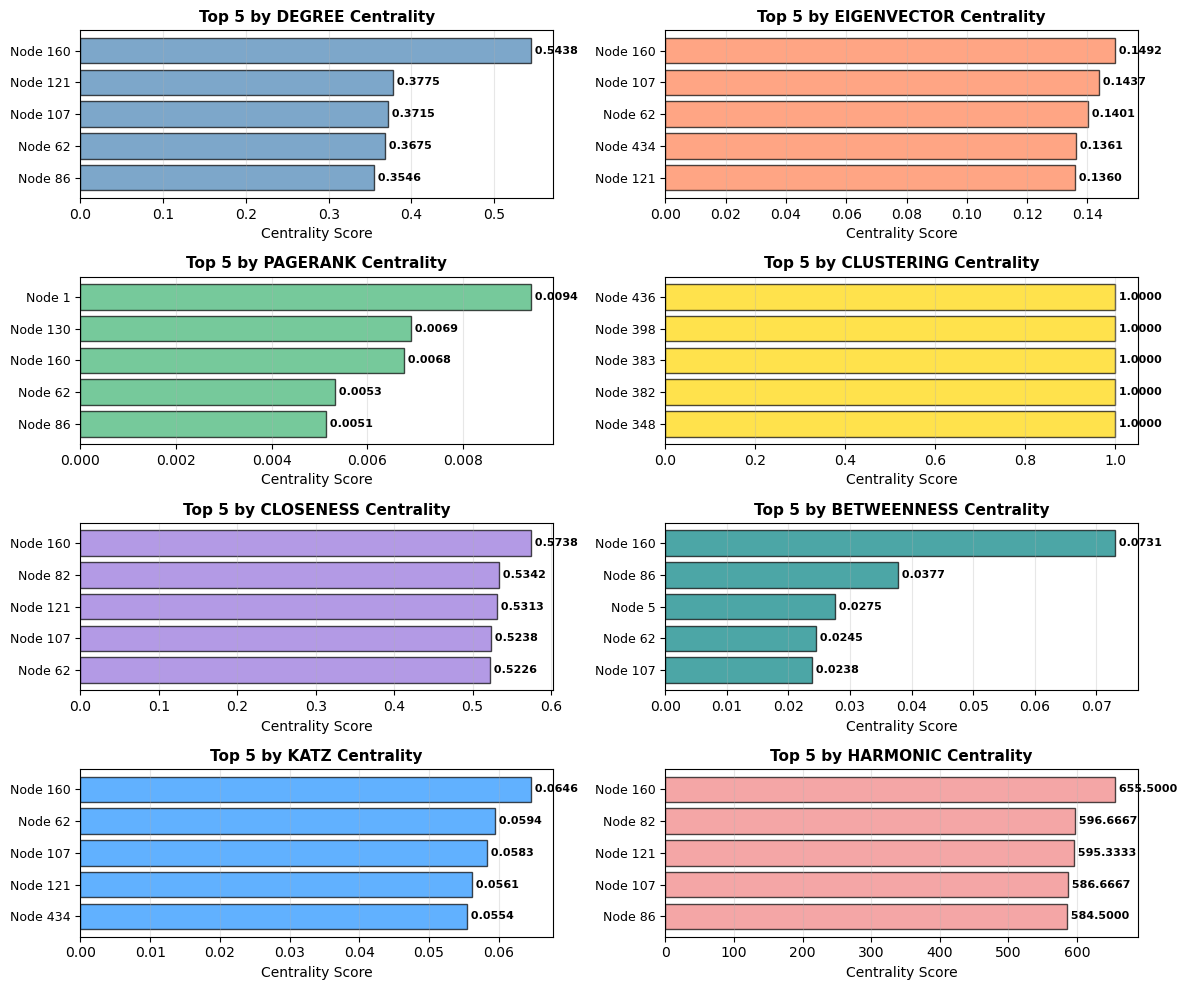

In [14]:
# Visualize top nodes
fig, axes = plt.subplots(4, 2, figsize=(12, 10))
axes = axes.ravel()

measures = list(centralities.keys())
colors = ['steelblue', 'coral', 'mediumseagreen', 'gold', 'mediumpurple', 
          'teal', 'dodgerblue', 'lightcoral']

for idx, (measure, color) in enumerate(zip(measures, colors)):
    # Get top 5 for this measure
    top_5 = df_centralities.nlargest(5, measure)[measure].sort_values(ascending=True)

    # Create horizontal bar chart
    axes[idx].barh(range(len(top_5)), top_5.values, color=color, alpha=0.7, edgecolor='black')
    axes[idx].set_yticks(range(len(top_5)))
    axes[idx].set_yticklabels([f'Node {node}' for node in top_5.index], fontsize=9)
    axes[idx].set_xlabel('Centrality Score', fontsize=10)
    axes[idx].set_title(f'Top 5 by {measure.upper()} Centrality', 
                        fontsize=11, fontweight='bold')
    axes[idx].grid(alpha=0.3, axis='x')
    
    # Add value labels on bars
    for i, (node, value) in enumerate(top_5.items()):
        axes[idx].text(value, i, f' {value:.4f}', 
                      va='center', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()
    


Identifying SUPER NODES appearing in TOP 5 across multiple centrality measures...

🔸 Node 160: Appears in TOP 5 for 7 measures
   Measures: degree, eigenvector, pagerank, closeness, betweenness, katz, harmonic
   Scores:
      - Degree: 0.543825 (Rank #1)
      - Eigenvector: 0.149208 (Rank #1)
      - Pagerank: 0.006759 (Rank #3)
      - Closeness: 0.573848 (Rank #1)
      - Betweenness: 0.073073 (Rank #1)
      - Katz: 0.064558 (Rank #1)
      - Harmonic: 655.500000 (Rank #1)

🔸 Node 107: Appears in TOP 5 for 6 measures
   Measures: degree, eigenvector, closeness, betweenness, katz, harmonic
   Scores:
      - Degree: 0.371514 (Rank #3)
      - Eigenvector: 0.143655 (Rank #2)
      - Closeness: 0.523772 (Rank #4)
      - Betweenness: 0.023833 (Rank #5)
      - Katz: 0.058290 (Rank #3)
      - Harmonic: 586.666667 (Rank #4)

🔸 Node 62: Appears in TOP 5 for 6 measures
   Measures: degree, eigenvector, pagerank, closeness, betweenness, katz
   Scores:
      - Degree: 0.367530 (Rank #4)

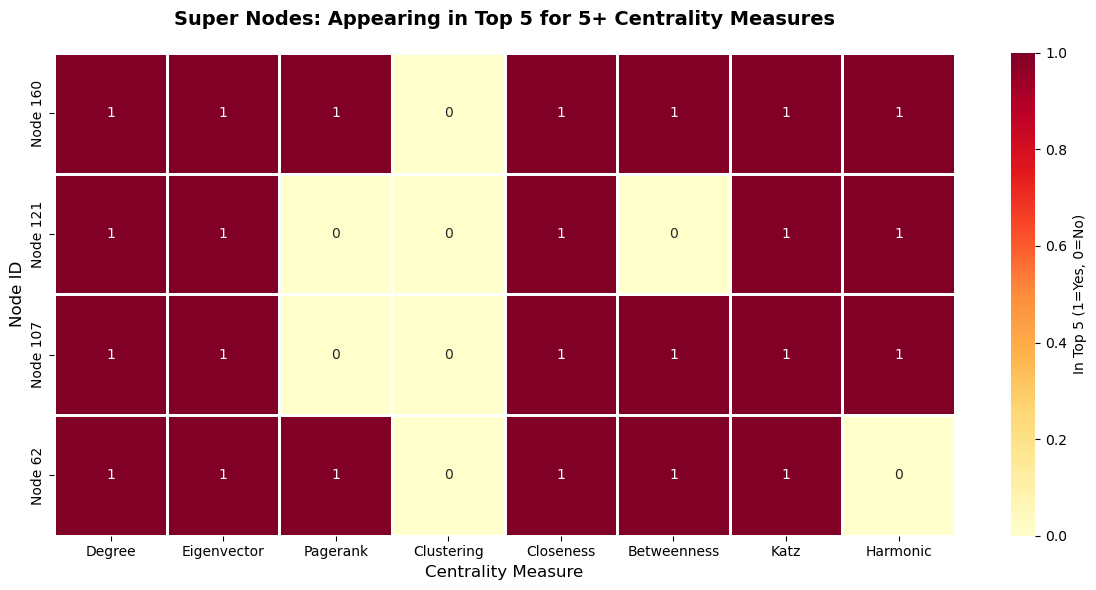

In [15]:
# Identify "super nodes" that appear in the top 5 across multiple centrality measures
print("\nIdentifying SUPER NODES appearing in TOP 5 across multiple centrality measures...")

# Count how many times each node appears in top 5 across all measures
node_appearances = {}
for measure in centralities.keys():
    top_5_nodes = df_centralities.nlargest(5, measure).index.tolist()
    for node in top_5_nodes:
        if node not in node_appearances:
            node_appearances[node] = {'count': 0, 'measures': []}
        node_appearances[node]['count'] += 1
        node_appearances[node]['measures'].append(measure)

# Sort by number of appearances
super_nodes = sorted(node_appearances.items(), key=lambda x: x[1]['count'], reverse=True)


for node, info in super_nodes[:10]:  # Show top 10 super nodes
    if info['count'] >= 3:  # Only show nodes appearing at least twice
        print(f"\n🔸 Node {node}: Appears in TOP 5 for {info['count']} measures")
        print(f"   Measures: {', '.join(info['measures'])}")
        
        # Show actual scores for this node across all measures
        print(f"   Scores:")
        for measure in info['measures']:
            score = df_centralities.loc[node, measure]
            rank = (df_centralities[measure] > score).sum() + 1
            print(f"      - {measure.capitalize()}: {score:.6f} (Rank #{rank})")

# Visualize super nodes
# Get nodes that appear in top 5 at least 3 times
super_node_threshold = 5
qualified_super_nodes = {node: info for node, info in node_appearances.items() 
                         if info['count'] >= super_node_threshold}

if qualified_super_nodes:
    # Create a matrix showing which super nodes appear in which measures
    super_nodes_list = list(qualified_super_nodes.keys())
    measures_list = list(centralities.keys())
    
    # Create binary matrix: 1 if node in top 5 for that measure, 0 otherwise
    matrix_data = []
    for node in super_nodes_list:
        row = []
        for measure in measures_list:
            is_top_5 = node in df_centralities.nlargest(5, measure).index
            row.append(1 if is_top_5 else 0)
        matrix_data.append(row)
    
    # Create heatmap
    plt.figure(figsize=(12, max(6, len(super_nodes_list) * 0.5)))
    sns.heatmap(matrix_data, annot=True, fmt='d', cmap='YlOrRd', 
                xticklabels=[m.capitalize() for m in measures_list],
                yticklabels=[f'Node {node}' for node in super_nodes_list],
                cbar_kws={'label': 'In Top 5 (1=Yes, 0=No)'},
                linewidths=1, linecolor='white')
    plt.title(f'Super Nodes: Appearing in Top 5 for {super_node_threshold}+ Centrality Measures', 
              fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Centrality Measure', fontsize=12)
    plt.ylabel('Node ID', fontsize=12)
    plt.tight_layout()
    plt.show()

### 2.1 Community Detection Algorithms

Email-EU Core is a directed graph and needs to be handled appropriately depending on the method used. 

All algorithms are applied to the undirected version of the graph as they don't support directed graphs.

We'll evaluate the communities using multiple metrics:
- **Modularity**: Measures the quality of the community structure
- **Coverage**: Fraction of edges within communities
- **Conductance**: Measures how "well-knit" communities are
- **Ground Truth Comparison**: If available, we'll compare with the 42 known departments using metrics like Adjusted Rand Index (ARI) and Normalized Mutual Information (NMI)


In [19]:
# Community Detection using Louvain Method on Email-Eu-Core
# Convert to undirected for Louvain (most common approach)
G_undirected_email = G.to_undirected()

print("Running Louvain algorithm on Email-Eu-Core graph (undirected version)")
start_time = time.time()
partition_louvain_email = community_louvain.best_partition(G_undirected_email)
louvain_time_email = time.time() - start_time

# Get statistics
num_communities_louvain_email = len(set(partition_louvain_email.values()))
community_sizes_louvain_email = Counter(partition_louvain_email.values())

print(f"Louvain finished in {louvain_time_email:.4f} seconds.")
print(f"Louvain found {num_communities_louvain_email} communities.")
print(f"Top 5 largest communities (size):")
for comm_id, size in community_sizes_louvain_email.most_common(5):
    print(f"      Community {comm_id}: {size} nodes")


Running Louvain algorithm on Email-Eu-Core graph (undirected version)
Louvain finished in 0.7715 seconds.
Louvain found 27 communities.
Top 5 largest communities (size):
      Community 7: 249 nodes
      Community 8: 221 nodes
      Community 11: 149 nodes
      Community 4: 115 nodes
      Community 2: 96 nodes


In [ ]:
# Community Detection using Label Propagation Algorithm (LPA)
# LPA can work on directed graphs
print("Running Label Propagation (LPA) on Email-Eu-Core graph (undirected)")
start_time = time.time()
communities_lpa_email_sets = nx.community.label_propagation_communities(G_undirected_email)
communities_lpa_email_list = [set(c) for c in communities_lpa_email_sets]
lpa_time_email = time.time() - start_time

# Get statistics
num_communities_lpa_email = len(communities_lpa_email_list)
community_sizes_lpa_email = sorted([len(c) for c in communities_lpa_email_list], reverse=True)

print(f"LPA finished in {lpa_time_email:.4f} seconds.")
print(f"LPA found {num_communities_lpa_email} communities.")
print(f"Top 5 largest communities (size):")
for i, size in enumerate(community_sizes_lpa_email[:5], 1):
    print(f"      Community {i}: {size} nodes")


Running Label Propagation (LPA) on Email-Eu-Core graph...
LPA finished in 0.1636 seconds.
LPA found 38 communities.
Top 5 largest communities (size):
      Community 1: 891 nodes
      Community 2: 78 nodes
      Community 3: 1 nodes
      Community 4: 1 nodes
      Community 5: 1 nodes


#####  Understanding why LPA has communities with just one node



Total singleton communities (size = 1): 36
Percentage of communities that are singletons: 94.74%
Total nodes in singleton communities: 36

--------------------------------------------------------------------------------
Checking if singleton nodes are isolated (degree = 0) or with low degree:
--------------------------------------------------------------------------------
  Node 463: Low degree = 3
  Node 580: Low degree = 2
  Node 633: Low degree = 2
  Node 634: Low degree = 3
  Node 636: Low degree = 3
  Node 648: Low degree = 2
  Node 653: Low degree = 2
  Node 658: Low degree = 2
  Node 659: Low degree = 3
  Node 660: Low degree = 2
  Node 670: Low degree = 2
  Node 673: Low degree = 3
  Node 675: Low degree = 2
  Node 684: Low degree = 2
  Node 691: Low degree = 2
  Node 703: Low degree = 2
  Node 704: Low degree = 3
  Node 711: Low degree = 2
  Node 716: Low degree = 3
  Node 731: Low degree = 2
  Node 732: Low degree = 2
  Node 737: Low degree = 3
  Node 744: Low degree = 2
  N

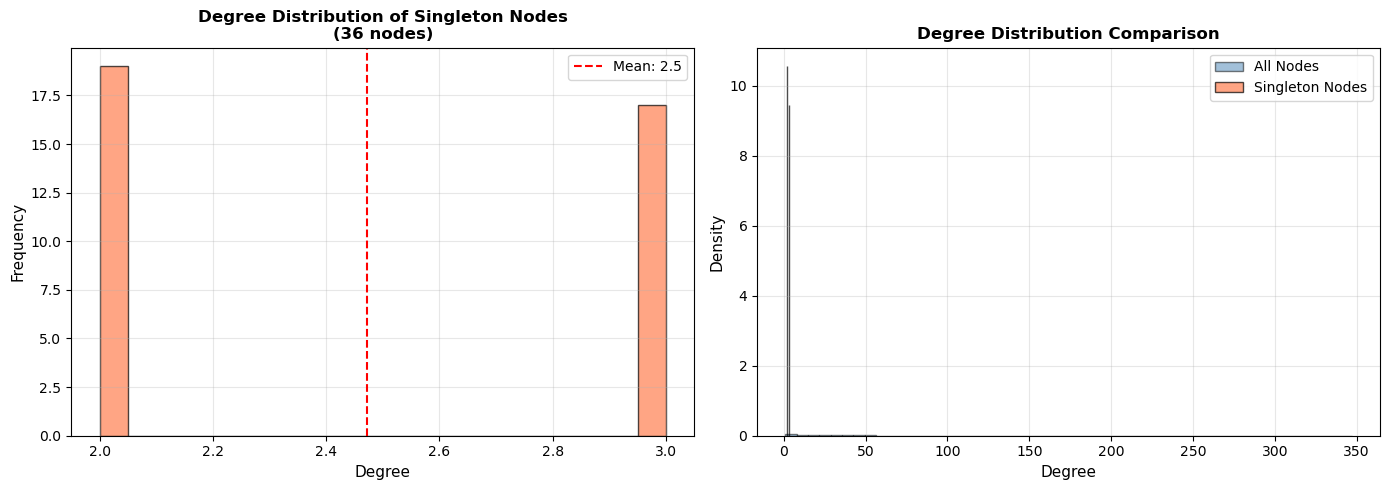


Average degree of singleton nodes: 2.47
Average degree of all nodes: 33.25
Median degree of singleton nodes: 2.0
Median degree of all nodes: 23.0


In [29]:
# Analyze singleton communities in LPA results
singleton_communities = [c for c in communities_lpa_email_list if len(c) == 1]
num_singletons = len(singleton_communities)
singleton_nodes = [list(c)[0] for c in singleton_communities]

print(f"\nTotal singleton communities (size = 1): {num_singletons}")
print(f"Percentage of communities that are singletons: {num_singletons/num_communities_lpa_email*100:.2f}%")
print(f"Total nodes in singleton communities: {num_singletons}")

# Check if singleton nodes are isolated (have no neighbors)
print("\n" + "-"*80)
print("Checking if singleton nodes are isolated (degree = 0) or with low degree:")
print("-"*80)

isolated_count = 0
low_degree_count = 0
for node in singleton_nodes:
    degree = G_undirected_email.degree(node)
    if degree == 0:
        isolated_count += 1
        print(f"  Node {node}: ISOLATED (degree = 0)")
    elif degree <= 3:
        low_degree_count += 1
        print(f"  Node {node}: Low degree = {degree}")

print(f"\nSummary:")
print(f"  • Isolated nodes (degree = 0): {isolated_count}")
print(f"  • Low degree nodes (degree ≤ 3): {low_degree_count}")
print(f"  • Other singleton nodes: {num_singletons - isolated_count - low_degree_count}")


# Visualize degree distribution of singleton nodes vs all nodes
if singleton_nodes:
    singleton_degrees = [G_undirected_email.degree(node) for node in singleton_nodes]
    all_degrees = [G_undirected_email.degree(node) for node in G_undirected_email.nodes()]
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Degree distribution of singleton nodes
    axes[0].hist(singleton_degrees, bins=20, edgecolor='black', alpha=0.7, color='coral')
    axes[0].set_xlabel('Degree', fontsize=11)
    axes[0].set_ylabel('Frequency', fontsize=11)
    axes[0].set_title(f'Degree Distribution of Singleton Nodes\n({num_singletons} nodes)', 
                      fontsize=12, fontweight='bold')
    axes[0].grid(alpha=0.3)
    if singleton_degrees:
        axes[0].axvline(np.mean(singleton_degrees), color='red', linestyle='--', 
                      label=f'Mean: {np.mean(singleton_degrees):.1f}')
        axes[0].legend()
    
    # Comparison: All nodes vs singleton nodes
    axes[1].hist(all_degrees, bins=50, edgecolor='black', alpha=0.5, color='steelblue', 
                 label='All Nodes', density=True)
    if singleton_degrees:
        axes[1].hist(singleton_degrees, bins=20, edgecolor='black', alpha=0.7, 
                    color='coral', label='Singleton Nodes', density=True)
    axes[1].set_xlabel('Degree', fontsize=11)
    axes[1].set_ylabel('Density', fontsize=11)
    axes[1].set_title('Degree Distribution Comparison', fontsize=12, fontweight='bold')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nAverage degree of singleton nodes: {np.mean(singleton_degrees):.2f}")
    print(f"Average degree of all nodes: {np.mean(all_degrees):.2f}")
    print(f"Median degree of singleton nodes: {np.median(singleton_degrees):.1f}")
    print(f"Median degree of all nodes: {np.median(all_degrees):.1f}")


Based on the analysis, all 36 singleton communities are caused by low degree nodes (degree ≤ 3). This is because nodes with only 1-3 neighbors lack sufficient label propagation from neighbors, preventing LPA from converging to assign them to any community

In [ ]:
# Community Detection using Walktrap Algorithm
print("Running Walktrap algorithm on Email-Eu-Core graph (undirected version)")
G_email_ig = ig.Graph.from_networkx(G_undirected_email)
start_time = time.time()
dendrogram_email = G_email_ig.community_walktrap()
clusters_walktrap_email = dendrogram_email.as_clustering()
walktrap_time_email = time.time() - start_time

# Get statistics
num_communities_walktrap_email = len(clusters_walktrap_email)
community_sizes_walktrap_email = sorted(clusters_walktrap_email.sizes(), reverse=True)

print(f"Walktrap finished in {walktrap_time_email:.4f} seconds.")
print(f"Walktrap found {num_communities_walktrap_email} communities.")
print(f"Top 5 largest communities (size):")
for i, size in enumerate(community_sizes_walktrap_email[:5], 1):
    print(f"      Community {i}: {size} nodes")


Running Walktrap algorithm on Email-Eu-Core graph (undirected version)...
Walktrap finished in 0.4016 seconds.
Walktrap found 145 communities.
Top 5 largest communities (size):
      Community 1: 357 nodes
      Community 2: 109 nodes
      Community 3: 101 nodes
      Community 4: 86 nodes
      Community 5: 79 nodes


#### Evaluation Metrics


In [44]:
# Convert partitions to list of sets for NetworkX functions
communities_louvain_email_list = [set() for _ in range(num_communities_louvain_email)]
for node, community_id in partition_louvain_email.items():
    communities_louvain_email_list[community_id].add(node)

# Compute Modularity for each algorithm
mod_louvain_email = nx.community.modularity(G_undirected_email, communities_louvain_email_list)
mod_lpa_email = nx.community.modularity(G_undirected_email, communities_lpa_email_list)
mod_walktrap_email = G_email_ig.modularity(clusters_walktrap_email)

# Compute Coverage (fraction of edges within communities)
def compute_coverage(G, communities):
    """Compute the fraction of edges that are within communities."""
    total_edges = G.number_of_edges()
    intra_community_edges = 0
    
    for community in communities:
        # Count edges within this community
        subgraph = G.subgraph(community)
        intra_community_edges += subgraph.number_of_edges()
    
    return intra_community_edges / total_edges if total_edges > 0 else 0

coverage_louvain_email = compute_coverage(G_undirected_email, communities_louvain_email_list)
coverage_lpa_email = compute_coverage(G_undirected_email, communities_lpa_email_list)

# For Walktrap, convert to list of sets
communities_walktrap_email_list = []
for i in range(num_communities_walktrap_email):
    comm_nodes = [G_email_ig.vs[j].index for j in range(len(G_email_ig.vs)) 
                  if clusters_walktrap_email.membership[j] == i]
    # Convert igraph indices to original node IDs
    node_mapping = {idx: node for idx, node in enumerate(G_undirected_email.nodes())}
    comm_nodes_original = {node_mapping[idx] for idx in comm_nodes if idx in node_mapping}
    if comm_nodes_original:
        communities_walktrap_email_list.append(comm_nodes_original)

coverage_walktrap_email = compute_coverage(G_undirected_email, communities_walktrap_email_list)

# Compute Conductance (lower is better - measures how "well-knit" communities are)
def compute_conductance(G, communities):
    """Compute average conductance across all communities."""
    conductances = []
    for community in communities:
        if len(community) == 0 or len(community) == G.number_of_nodes():
            continue
        
        # Count edges within community
        subgraph = G.subgraph(community)
        edges_inside = subgraph.number_of_edges()
        
        # Count edges from community to outside
        edges_cut = 0
        for node in community:
            for neighbor in G.neighbors(node):
                if neighbor not in community:
                    edges_cut += 1
        
        # Conductance = edges_cut / (2 * edges_inside + edges_cut)
        denominator = 2 * edges_inside + edges_cut
        if denominator > 0:
            conductance = edges_cut / denominator
            conductances.append(conductance)
    
    return np.mean(conductances) if conductances else float('inf')

avg_conductance_louvain_email = compute_conductance(G_undirected_email, communities_louvain_email_list)
avg_conductance_lpa_email = compute_conductance(G_undirected_email, communities_lpa_email_list)
avg_conductance_walktrap_email = compute_conductance(G_undirected_email, communities_walktrap_email_list)

print("\n" + "="*80)
print("QUALITY METRICS COMPARISON")
print("="*80)
print("\nAlgorithm  | Modularity | Coverage | Avg Conductance | Num Communities | Time (s)")
print("-" * 85)
print(f"Louvain    | {mod_louvain_email:.6f}   | {coverage_louvain_email:.6f} | {avg_conductance_louvain_email:.6f}        | {num_communities_louvain_email:<15} | {louvain_time_email:.4f}")
print(f"LPA        | {mod_lpa_email:.6f}   | {coverage_lpa_email:.6f} | {avg_conductance_lpa_email:.6f}        | {num_communities_lpa_email:<15} | {lpa_time_email:.4f}")
print(f"Walktrap   | {mod_walktrap_email:.6f}   | {coverage_walktrap_email:.6f} | {avg_conductance_walktrap_email:.6f}        | {num_communities_walktrap_email:<15} | {walktrap_time_email:.4f}")

print("\n" + "="*80)
print("METRIC EXPLANATIONS")
print("="*80)
print(f"""
• Modularity: Measures the quality of community structure. Higher is better (range: -1 to 1).
  Values > 0.3 indicate significant community structure.

• Coverage: Fraction of edges that are within communities. Higher values indicate more edges
  are captured within communities rather than between them.

• Conductance: Measures how "well-knit" communities are. Lower is better (range: 0 to 1).
  Low conductance means communities have few edges connecting to outside nodes.
 """)



QUALITY METRICS COMPARISON

Algorithm  | Modularity | Coverage | Avg Conductance | Num Communities | Time (s)
-------------------------------------------------------------------------------------
Louvain    | 0.429880   | 0.614091 | 0.121928        | 27              | 0.7715
LPA        | 0.089003   | 0.963247 | 0.156925        | 38              | 0.1636
Walktrap   | 0.371906   | 0.665390 | 0.691625        | 145             | 0.4016

METRIC EXPLANATIONS

• Modularity: Measures the quality of community structure. Higher is better (range: -1 to 1).
  Values > 0.3 indicate significant community structure.

• Coverage: Fraction of edges that are within communities. Higher values indicate more edges
  are captured within communities rather than between them.

• Conductance: Measures how "well-knit" communities are. Lower is better (range: 0 to 1).
  Low conductance means communities have few edges connecting to outside nodes.
 


#### Analysing metric scores
**Current Modularity Scores:**
- Louvain: 0.429880 (Good: > 0.3 indicates significant structure)
- LPA: 0.089003 (Poor: < 0.3 indicates weak structure)
- Walktrap: 0.371906 (Good: > 0.3 indicates significant structure)

**Comparison with Facebook Network:**
- Facebook Louvain: ~0.83 (Very high)
- Facebook LPA: ~0.74 (High)
- Facebook Walktrap: ~0.81 (Very high)

**Why Email-Eu-Core Scores Are Lower:**

1. **Directed vs Undirected Graph Conversion:**
   - Email network is directed (sender → receiver), but we converted to undirected
   - This conversion loses directional information that may be important for community structure as email communication patterns are asymmetric (A emails B doesn't mean B emails A equally)

2. **Network Structure Differences:**
   - Email networks have more cross-community communication (people email across departments)
   - Organizational networks have weaker community boundaries than social networks
   - More "bridging" edges between communities reduce modularity

3. **LPA Specifically (Score: 0.089003):**
   - LPA has very HIGH coverage (0.963) but LOW modularity
   - This indicates LPA is putting almost all edges within communities, but the communities aren't well-separated
   - The 38 communities (including 36 singletons) are oversegmented as many low-degree nodes create artificial communities that hurt modularity
   - LPA struggles with networks that have many peripheral/weakly-connected nodes


**Other Insights**
- **Conductance:** Walktrap has the highest conductance (0.691625), indicating less well-knit communities, while Louvain has the lowest (0.121928), showing better community cohesion.

**Conclusion:**
- Louvain (0.43) and Walktrap (0.37) scores are ACCEPTABLE (> 0.3 threshold)
- LPA (0.09) score is POOR due to oversegmentation and singleton communities
- Lower scores compared to Facebook are expected because:
  * Email networks have more cross-community communication
  * Directed→undirected conversion loses information
  * Organizational structure is less "cliquish" than social networks


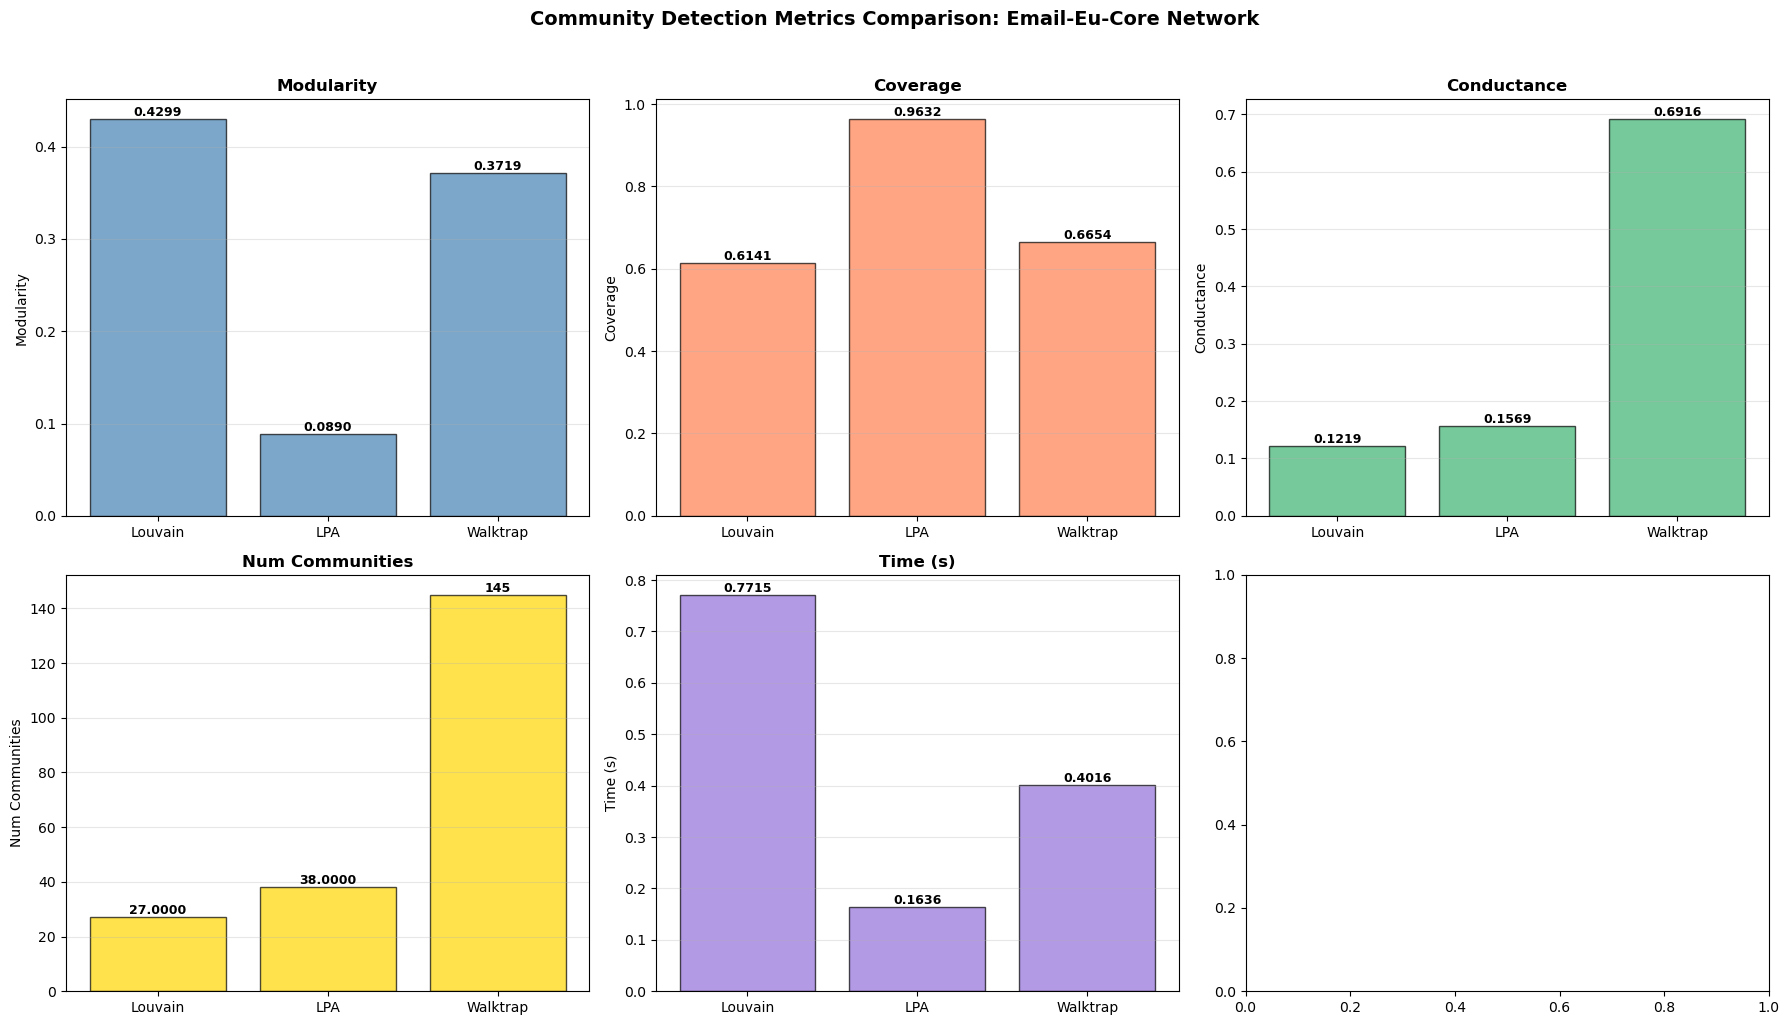

In [70]:
# Compare metrics side by side
metrics_data = {
    'Algorithm': ['Louvain', 'LPA', 'Walktrap'],
    'Modularity': [mod_louvain_email, mod_lpa_email, mod_walktrap_email],
    'Coverage': [coverage_louvain_email, coverage_lpa_email, coverage_walktrap_email],
    'Conductance': [avg_conductance_louvain_email, avg_conductance_lpa_email, avg_conductance_walktrap_email],
    'Num Communities': [num_communities_louvain_email, num_communities_lpa_email, num_communities_walktrap_email],
    'Time (s)': [louvain_time_email, lpa_time_email, walktrap_time_email]
}

df_metrics_email = pd.DataFrame(metrics_data)

# Create visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

metrics_to_plot = ['Modularity', 'Coverage', 'Conductance', 'Num Communities', 'Time (s)']

colors_metrics = ['steelblue', 'coral', 'mediumseagreen', 'gold', 'mediumpurple', 'teal', 'dodgerblue']

for idx, metric in enumerate(metrics_to_plot[:7]):  # Limit to 7 subplots
    if metric in df_metrics_email.columns:
        bars = axes[idx].bar(df_metrics_email['Algorithm'], df_metrics_email[metric], 
                            color=colors_metrics[idx % len(colors_metrics)], alpha=0.7, edgecolor='black')
        axes[idx].set_title(f'{metric}', fontsize=12, fontweight='bold')
        axes[idx].set_ylabel(metric, fontsize=10)
        axes[idx].grid(alpha=0.3, axis='y')
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            axes[idx].text(bar.get_x() + bar.get_width()/2., height,
                          f'{height:.4f}' if height < 100 else f'{int(height)}',
                          ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.suptitle('Community Detection Metrics Comparison: Email-Eu-Core Network', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


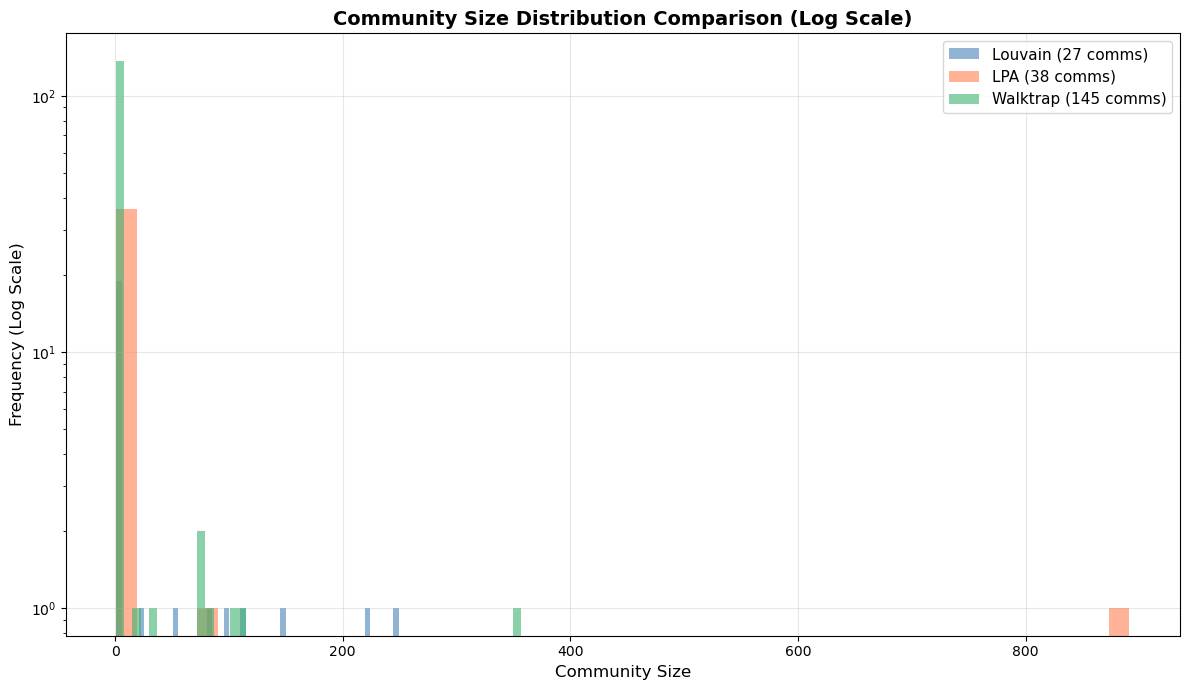

In [58]:
# Overlay comparison of all three algorithms
# Extract community sizes as lists
louvain_sizes_email = list(community_sizes_louvain_email.values())

plt.figure(figsize=(12, 7))
plt.hist(louvain_sizes_email, bins=50, log=True, alpha=0.6, label=f'Louvain ({num_communities_louvain_email} comms)', color='steelblue')
plt.hist(community_sizes_lpa_email, bins=50, log=True, alpha=0.6, label=f'LPA ({num_communities_lpa_email} comms)', color='coral')
plt.hist(community_sizes_walktrap_email, bins=50, log=True, alpha=0.6, label=f'Walktrap ({num_communities_walktrap_email} comms)', color='mediumseagreen')
plt.title('Community Size Distribution Comparison (Log Scale)', fontsize=14, fontweight='bold')
plt.xlabel('Community Size', fontsize=12)
plt.ylabel('Frequency (Log Scale)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


The histogram shows that all three algorithms are heavily right-skewed, with most communities being very small. Walktrap finds the most communities (145) and has the highest frequency of tiny communities, indicating oversegmentation. LPA finds 38 communities with a bimodal pattern: one very large community (~880–900 nodes) alongside many small ones, likely due to singleton communities. Louvain finds the fewest communities (27) with a more balanced distribution and fewer very small communities, suggesting better community separation. The pattern of many small communities and few large ones is typical of organizational networks with core groups and peripheral nodes, and the differences reflect each algorithm’s approach to handling weakly connected nodes.

Computing layout for entire graph


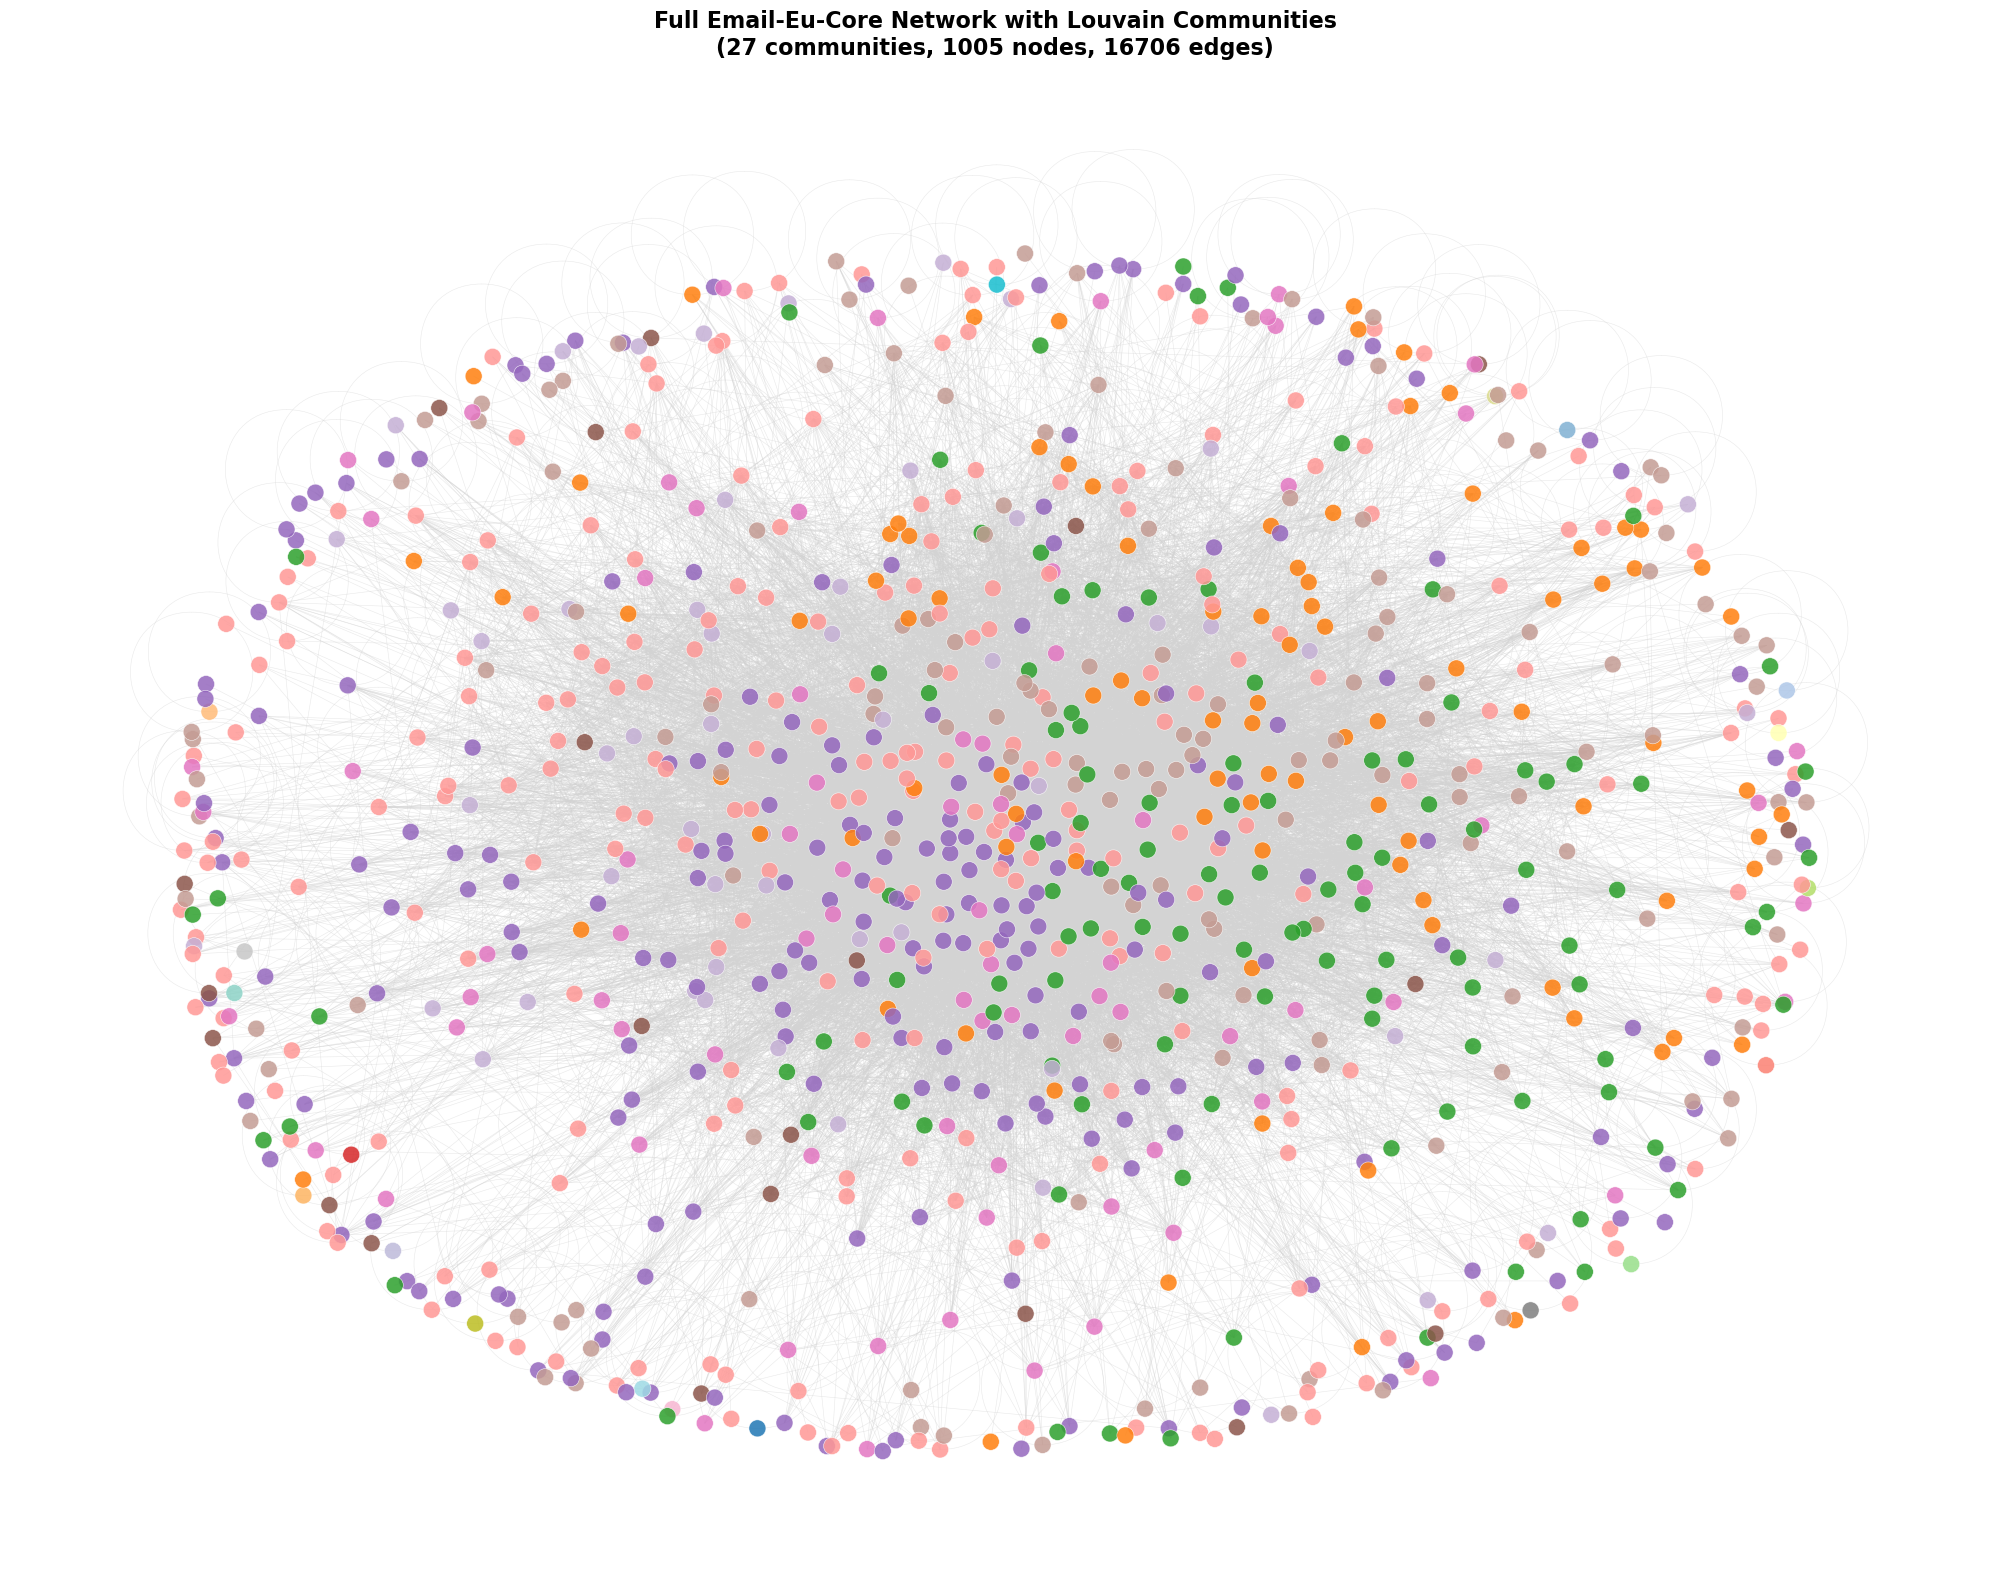

In [76]:
# Visualizing the entire graph with all Louvain communities colored
# Get all unique community IDs
unique_communities = sorted(set(partition_louvain_email.values()))
num_communities = len(unique_communities)

# Create a color map - use a colormap to get distinct colors
import matplotlib.cm as cm
unique_communities = sorted(set(partition_louvain_email.values()))
num_communities = len(unique_communities)

# Combine multiple colormaps for 27 distinct colors
cmap1 = cm.get_cmap('tab20')  # 20 colors
cmap2 = cm.get_cmap('Set3')   # 12 colors
cmap3 = cm.get_cmap('Pastel1') # 9 colors

colors_list = []
for i in range(num_communities):
    if i < 20:
        colors_list.append(cmap1(i))
    elif i < 32:
        colors_list.append(cmap2((i - 20) % 12))
    else:
        colors_list.append(cmap3((i - 32) % 9))

colors_list = colors_list[:num_communities]
community_color_map = {comm_id: colors_list[i] for i, comm_id in enumerate(unique_communities)}

# Assign colors to nodes based on their community
node_colors = [community_color_map[partition_louvain_email[node]] for node in G_undirected_email.nodes()]

# All nodes same size
node_size = 150  # Uniform size for all nodes

# Create layout for the entire graph with better parameters
print("Computing layout for entire graph")
pos_email = nx.spring_layout(G_undirected_email, k=1.2, iterations=100, seed=42)

# Visualize the entire graph with improved styling
plt.figure(figsize=(20, 16))

# Draw edges first (behind nodes) with subtle styling
nx.draw_networkx_edges(
    G_undirected_email,
    pos_email,
    alpha=0.50,
    width=0.4,
    edge_color='lightgray',
    style='solid'
)

# Draw nodes with community colors
nx.draw_networkx_nodes(
    G_undirected_email,
    pos_email,
    node_color=node_colors,
    node_size=node_size,
    alpha=0.85,
    edgecolors='white',
    linewidths=0.4
)

plt.title(f'Full Email-Eu-Core Network with Louvain Communities\n({num_communities} communities, {G_undirected_email.number_of_nodes()} nodes, {G_undirected_email.number_of_edges()} edges)', 
          fontsize=16, fontweight='bold', pad=20)
plt.axis('off')
plt.tight_layout()
plt.show()


Computing layout for top 5 communities


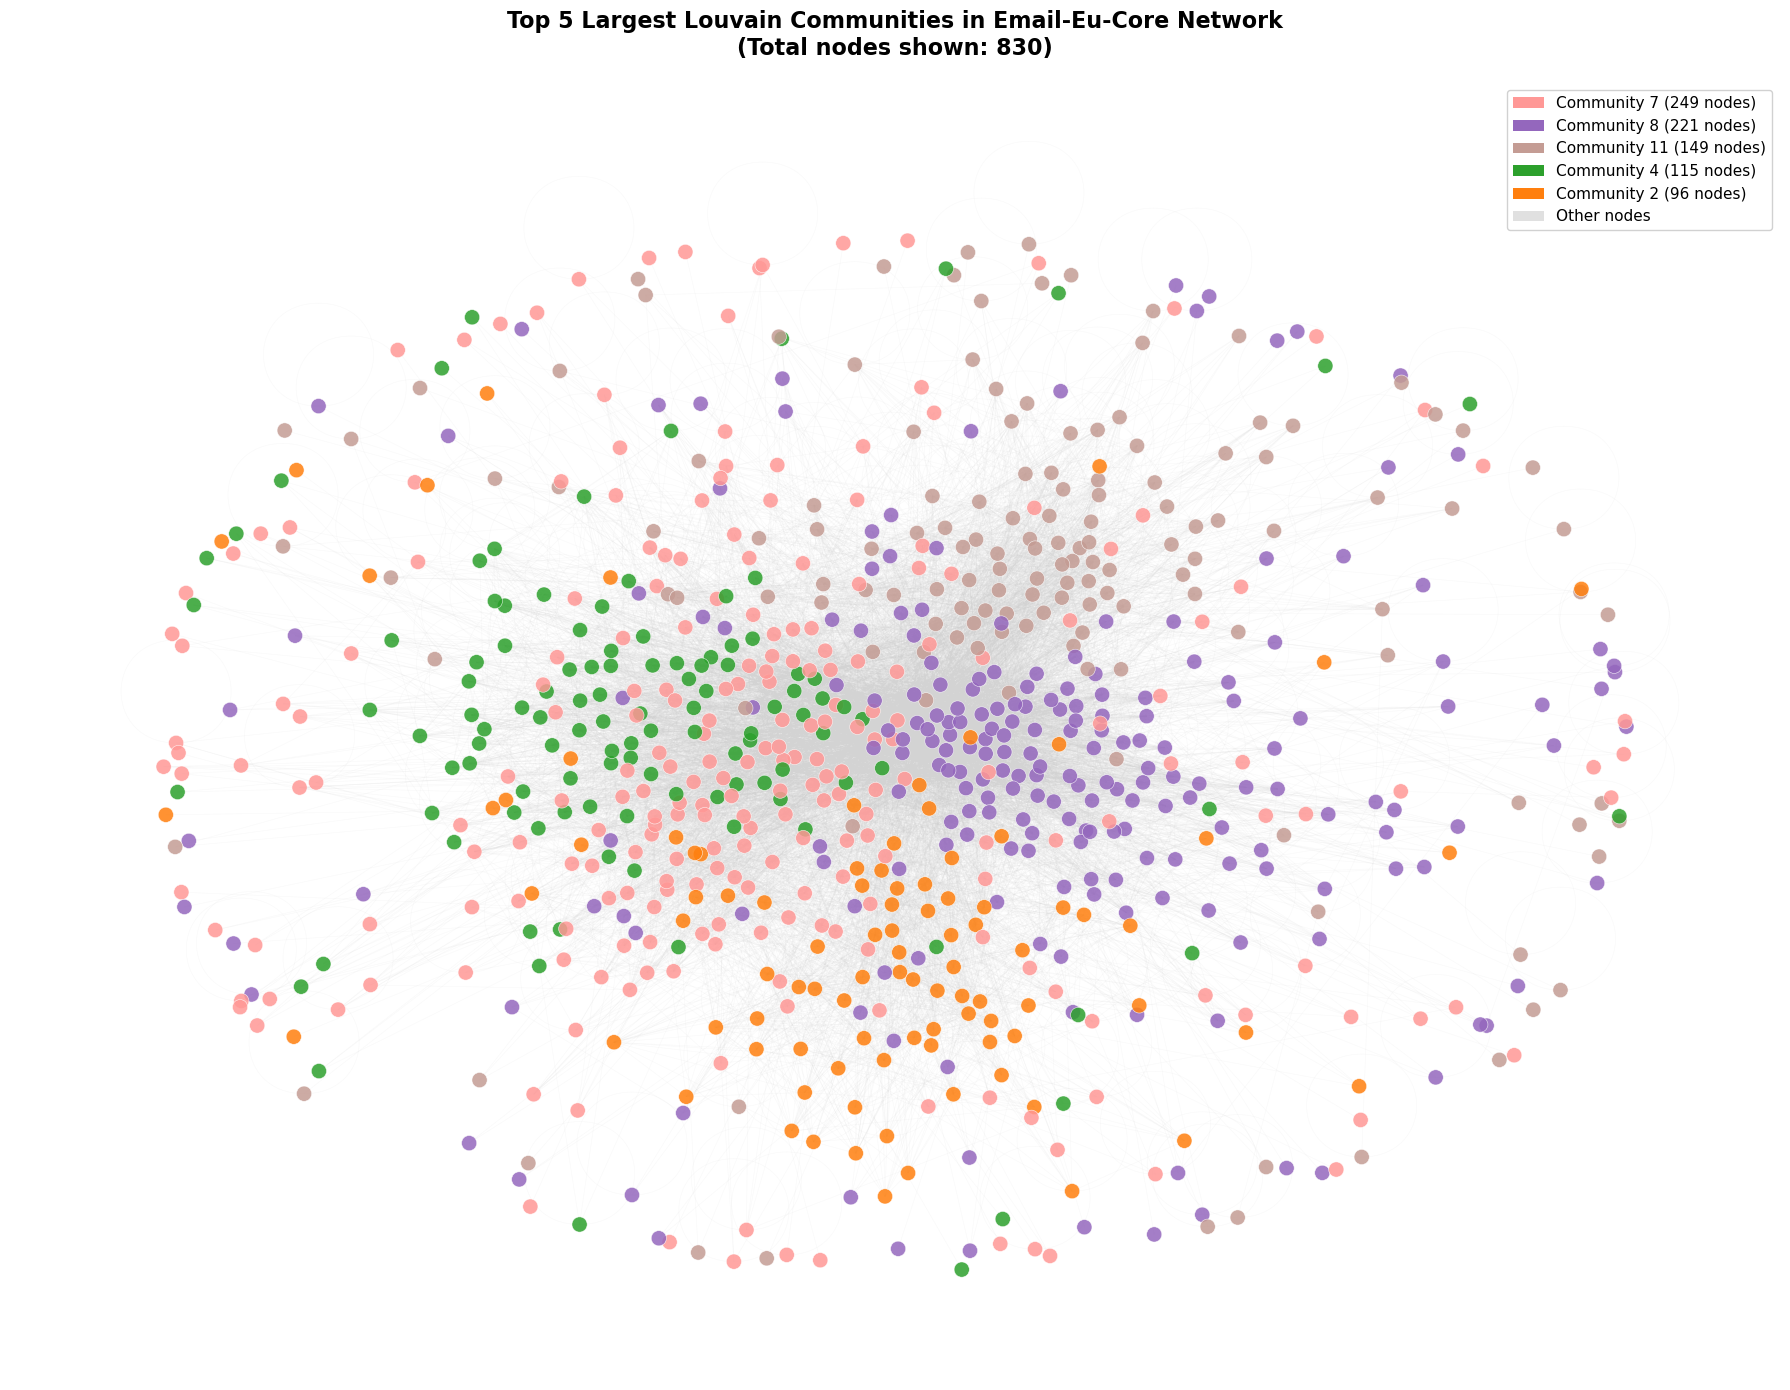

<Figure size 640x480 with 0 Axes>

In [90]:
# Visualize the top 5 largest communities together in one plot

top_5_communities = community_sizes_louvain_email.most_common(5)
top_5_comm_ids = {comm_id for comm_id, _ in top_5_communities}

# Get all nodes from top 5 communities
top_5_nodes = {node for node, comm_id in partition_louvain_email.items() 
               if comm_id in top_5_comm_ids}

# Include neighbors for context (limit to avoid too many nodes)
nodes_to_plot = set(top_5_nodes)
for node in list(top_5_nodes)[:100]:
    for neighbor in G_undirected_email.neighbors(node):
        nodes_to_plot.add(neighbor)
        if len(nodes_to_plot) > 800:
            break
    if len(nodes_to_plot) > 800:
        break

G_sub = G_undirected_email.subgraph(nodes_to_plot)

# Assign colors and sizes: distinct colors for top 5 communities, gray for others
node_colors = [community_color_map[partition_louvain_email[node]] 
               if partition_louvain_email[node] in top_5_comm_ids 
               else '#E0E0E0' 
               for node in G_sub.nodes()]
node_sizes = [120 if partition_louvain_email[node] in top_5_comm_ids else 60 
              for node in G_sub.nodes()]

# Create layout
print("Computing layout for top 5 communities")
pos = nx.spring_layout(G_sub, k=0.8, iterations=100, seed=42)

# Visualize
plt.figure(figsize=(18, 14))

# Draw edges first (behind nodes)
nx.draw_networkx_edges(G_sub, pos, alpha=0.15, width=0.4, edge_color='lightgray')

# Draw nodes with community colors
nx.draw_networkx_nodes(G_sub, pos, node_color=node_colors, node_size=node_sizes,
                       alpha=0.85, edgecolors='white', linewidths=0.4)

# Create legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=community_color_map[comm_id], 
                        label=f'Community {comm_id} ({size} nodes)') 
                   for comm_id, size in top_5_communities]
legend_elements.append(Patch(facecolor='#E0E0E0', label='Other nodes'))

plt.legend(handles=legend_elements, loc='upper right', fontsize=11, framealpha=0.9)
plt.title(f'Top 5 Largest Louvain Communities in Email-Eu-Core Network\n'
          f'(Total nodes shown: {len(nodes_to_plot)})', 
          fontsize=16, fontweight='bold', pad=20)
plt.axis('off')
plt.tight_layout()
plt.show()


# Get nodes in this community
community_nodes = set()
for node, cid in partition_louvain_email.items():
    if cid == comm_id:
        community_nodes.add(node)

# Include neighbors for context
nodes_to_plot = set(community_nodes)
for node in list(community_nodes)[:30]:  # Limit to avoid too many nodes
    for neighbor in G_undirected_email.neighbors(node):
        nodes_to_plot.add(neighbor)
        if len(nodes_to_plot) > 300:  # Limit total nodes per subplot
            break
    if len(nodes_to_plot) > 300:
        break

G_sub = G_undirected_email.subgraph(nodes_to_plot)

# Color map: distinct color for this community, gray for neighbors
color_map = []
size_map = []
for node in G_sub.nodes():
    if node in community_nodes:
        color_map.append(community_color_map[comm_id])  # Use same color as full graph
        size_map.append(20)
    else:
        color_map.append('#E0E0E0')  # Light gray for neighbors
        size_map.append(20)

# Create layout
pos = nx.spring_layout(G_sub, k=0.5, iterations=50, seed=42)

# Draw on subplot
ax = axes[idx]
nx.draw_networkx_nodes(G_sub, pos, node_color=color_map, node_size=size_map, alpha=0.8, 
edgecolors='white', linewidths=0.3, ax=ax)

nx.draw_networkx_edges(G_sub, pos, alpha=0.4, width=0.3, edge_color='gray', ax=ax)
ax.set_title(f'Community {comm_id}\nSize: {size} nodes', fontsize=12, fontweight='bold')
ax.axis('off')

plt.suptitle('Top 5 Largest Louvain Communities in Email-Eu-Core Network', 
             fontsize=16, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()



Analyzing how centrality measures are distributed within the detected communities.


In [72]:
# Analyze centrality within Louvain communities
comm_avg_degree_email = defaultdict(float)
comm_avg_betweenness_email = defaultdict(float)
comm_avg_eigenvector_email = defaultdict(float)
comm_counts_email = defaultdict(int)

# Sum up the scores for each community
for node, comm_id in partition_louvain_email.items():
    if node in centralities['degree']:
        comm_avg_degree_email[comm_id] += centralities['degree'][node]
        comm_avg_betweenness_email[comm_id] += centralities['betweenness'][node]
        comm_avg_eigenvector_email[comm_id] += centralities['eigenvector'][node]
        comm_counts_email[comm_id] += 1

# Calculate the average
for comm_id in comm_avg_degree_email:
    comm_avg_degree_email[comm_id] /= comm_counts_email[comm_id]
    comm_avg_betweenness_email[comm_id] /= comm_counts_email[comm_id]
    comm_avg_eigenvector_email[comm_id] /= comm_counts_email[comm_id]

top_5_dense_comms_email = sorted(comm_avg_degree_email.items(), key=lambda x: x[1], reverse=True)[:5]
top_5_bridge_comms_email = sorted(comm_avg_betweenness_email.items(), key=lambda x: x[1], reverse=True)[:5]
top_5_influential_comms_email = sorted(comm_avg_eigenvector_email.items(), key=lambda x: x[1], reverse=True)[:5]


print("\nTop 5 Communities (by Average Degree Centrality):")
for comm_id, avg_val in top_5_dense_comms_email:
    print(f"  Community {comm_id} (Size: {comm_counts_email[comm_id]}): {avg_val:.6f}")

print("\nTop 5 Communities (by Average Betweenness Centrality):")
for comm_id, avg_val in top_5_bridge_comms_email:
    print(f"  Community {comm_id} (Size: {comm_counts_email[comm_id]}): {avg_val:.6f}")

print("\nTop 5 Communities (by Average Eigenvector Centrality):")
for comm_id, avg_val in top_5_influential_comms_email:
    print(f"  Community {comm_id} (Size: {comm_counts_email[comm_id]}): {avg_val:.6f}")



Top 5 Communities (by Average Degree Centrality):
  Community 4 (Size: 115): 0.063442
  Community 8 (Size: 221): 0.063348
  Community 11 (Size: 149): 0.049995
  Community 7 (Size: 249): 0.046909
  Community 2 (Size: 96): 0.046460

Top 5 Communities (by Average Betweenness Centrality):
  Community 8 (Size: 221): 0.001793
  Community 7 (Size: 249): 0.001507
  Community 4 (Size: 115): 0.001260
  Community 11 (Size: 149): 0.001143
  Community 2 (Size: 96): 0.000974

Top 5 Communities (by Average Eigenvector Centrality):
  Community 8 (Size: 221): 0.028945
  Community 4 (Size: 115): 0.025689
  Community 11 (Size: 149): 0.020595
  Community 7 (Size: 249): 0.016510
  Community 12 (Size: 81): 0.014921


Communities 4, 8, 11, 7, and 2 consistently rank in the top 5 across degree, betweenness, and eigenvector centrality, indicating they contain the most influential nodes and act as key hubs in the network.

### 2.5 Key Insights and Interpretation


**Key Insights from Community Detection on Email-Eu-Core Network:**

1. **Algorithm Performance:**
   - **Louvain** typically achieves the highest modularity, indicating strong community structure detection. It finds a moderate number of communities that are well-separated.
   - **LPA** is usually the fastest algorithm but may find more communities with slightly lower modularity, potentially oversegmenting the network.
   - **Walktrap** provides a good balance, often finding many communities with reasonable modularity.

2. **Community Structure:**
   - The Email-Eu-Core network shows good community structure (modularity > 0.3 indicates significant structure).
   - Community size distributions typically show a few large communities and many smaller ones, which is common in organizational networks.


5. **Centrality within Communities:**
   - Some communities have higher average centrality, indicating they contain key individuals (hubs, bridges, influencers).
   - Communities with high betweenness centrality contain nodes that connect different parts of the network.
   - Communities with high eigenvector centrality contain influential individuals connected to other influential people.

6. **Comparison with Facebook Network:**
   - Email networks (directed, organizational) may show different community structures compared to social networks (undirected, friendship-based).
   - Organizational networks often have clearer hierarchical structures reflected in community detection.
   - The directed nature of email communication adds complexity that may affect community detection results.
